Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as any collaborators you worked with:

In [1]:
COLLABORATORS = ""

## To receive credit for this assignment, you must also fill out the [AI Use survey](https://forms.gle/ZhR5k8TdAeN8rj4CA)


---

In [2]:
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
import pandas as pd

# Final Project

This notebook will provide a brief structure and rubric for presenting your final project. 

The purpose of the project is 2-fold
* To give you an opportunity to work on a problem you are truly interested in (as this is the best way to actually learn something)
* To demonstrate to me that you understand the overall workflow of problem solving from problem selection to implementation to discussion 

You can choose any subject area that interests you as long as there is a computational component to it.  However, please do not reuse projects or homeworks you have done in other classes.  This should be **your** original work.

**You can work in teams, but clearly identify each persons contribution** and every team member should hand in their own copy of the notebook.

### Structure
There are 5 parts for a total of 100 points that provide the overall structure of a mini research project.

* Abstract
* Introduction and Problem Description
* Brief discussion of Computational approach and import of any additional packages
* Implementation including tests
* Discussion of results and future directions

For grading purposes, please try to make this notebook entirely self contained. 

The project is worth about 2 problem sets and should be of comparable length (please: I will have about 100 of these to read and I am not expecting full 10 page papers).  The actual project does not necessarily have to work but in that case you should demonstrate that you understand why it did not work and what steps you would take next to fix it.

Have fun

## Abstract [10 pts]

Provide a 1-2 paragraph abstract of the project in the style of a research paper.  The abstract should contain

* A brief description of the problem
* A brief justification describing why this problem is important/interesting to you
* A general description of the computational approach
* A brief summary of what you did and what you learned


Cardiovascular diseases remain a leading cause of morbidity and mortality worldwide, and understanding blood flow behavior in compliant, viscoelastic vessels is critical for diagnosis, treatment planning, and medical device design. Consequently, developing efficient and accurate computational methods can provide clinicians and researchers with valuable insights into disease progression, surgical outcomes, and personalized medicine. The frequency-domain spectral element method (SEM) offers a computational advantage over the traditional finite element method (FEM) while maintaining high accuracy for the purposes of application.

We begin with the one-dimensional blood flow governing laws: the continuity equation, the momentum balance equation, and the constitutive equation. We linearize the equations to simplify the workflow. After linearization, we end with the time-domain governing equations in matrix form, for which we have two unknowns (blood pressure at the vessel inlet and blood flow rate at the vessel outlet) and two boundary conditions (blood flow rate at the inlet and blood pressure at the outlet). In the spectral method, we transform the equations into the frequency-domain and compute a solution in the frequency domain with the use of a dispersion relation and an exact dynamic stiffness matrix. We construct a linear SEM solver and a nonlinear SEM solver, and we verify the spectral method implementation using two simple test casees. For the FEM and the shooting method solvers, we work with the time-domain governing equations and discretize in time and space. We find that our FEM and shooting method solvers converge to the same solution. When comparing all three methods (subject to the same physiologic boundary conditions), we find that they produce similar solutions.

## Introduction [15 pts]

In ~4-5 paragraphs, describe 
* The general problem you want to solve
* Why it is important and what you hope to achieve.

Please provide basic **references**, particularly if you are reproducing results from a paper. Also include any basic equations you plan to solve. 

Please use proper spelling and grammar. 

For this project, we recreate a scaled-down version of the frequency-domain spectral element method presented in Lee and Jang (2012): we work with the linearized governing equations in the time-domain and frequency-domain and assume simplified physical parameters. 

Linearized governing equations:
$$\text{Linearized Continuity:} \quad \dot{a} + q' = \psi$$

$$\text{Linearized Momentum Balance:} \quad \dot{q} + \frac{2\gamma Q_d}{A_0}q' + \frac{A_0}{\rho}p' - \frac{\gamma Q_d^2}{A_0^2}a' - \nu q'' + \left(\frac{2\gamma\theta Q_d}{A_0} + \frac{\eta}{A_0}\right)q = f_{NL}$$

$$\text{Linearized Constitutive:} \quad p = \kappa a$$


Time-domain governing equations in matrix form:

$$\mathbf{M}\frac{\partial^2 \mathbf{u}}{\partial t^2} + \mathbf{C}\frac{\partial \mathbf{u}}{\partial t} + \mathbf{G}\frac{\partial^2 \mathbf{u}}{\partial x \partial t} + \mathbf{D}\frac{\partial^2 \mathbf{u}}{\partial x^2} + \mathbf{A}\frac{\partial \mathbf{u}}{\partial x} + \mathbf{K}\mathbf{u} = \mathbf{0}$$

where $\mathbf{u} = \begin{Bmatrix} p \\ q \end{Bmatrix}$ and the coefficient matrices are:

$$\mathbf{M} = \begin{bmatrix} 0 & 0 \\ 0 & 0 \end{bmatrix}, \quad
\mathbf{C} = \begin{bmatrix} \frac{1}{\kappa} & 0 \\ 0 & 1 \end{bmatrix}, \quad
\mathbf{G} = \begin{bmatrix} 0 & 0 \\ 0 & 0 \end{bmatrix}$$

$$\mathbf{D} = \begin{bmatrix} 0 & 0 \\ 0 & -\nu \end{bmatrix}, \quad
\mathbf{A} = \begin{bmatrix} 0 & 1 \\ c_2 & u \end{bmatrix}, \quad
\mathbf{K} = \begin{bmatrix} 0 & 0 \\ 0 & \alpha \end{bmatrix}$$


Frequency-domain governing equations in matrix form:

$$\mathbf{D}\bar{\mathbf{u}}'' + \mathbf{H}\bar{\mathbf{u}}' + \mathbf{L}\bar{\mathbf{u}} = \bar{\mathbf{f}}_e + \bar{\mathbf{f}}_{NL}$$

in which the coefficient matrices are:
$$\mathbf{H} = i\omega\mathbf{G} + \mathbf{A}, \qquad \mathbf{L} = i\omega\mathbf{C} + \mathbf{K} - \omega^2\mathbf{M}$$


We differentiate between a linear SEM and nonlinear SEM solver, for which we introduce a nonlinear forcing term in the latter to better simulate blood flow conditions in an elastic vessel. In addition to the SEM solvers, we attempt a finite element method model as well as a shooting method model for comparison to the SEM.

Lee and Jang (2012) showed that a nonlinear frequency-domain SEM solver produces a highly accurate solution that their reference FEM converges to. They further applied their SEM to demonstrate physical properties of the blood vessel, including that nonlinear terms in the governing equations have little effect on transient responses of blood flow rate and pressure and that viscoelasticity of the vessel wall introduces a slight attenuation in flow rate and pressure. Overall, they demonstrated a computationally efficient one-dimensional nonlinear spectral element model that may be used to efficiently deduce blood flow characteristics related to cardiovascular disease.

Wan et al. (2002) introduced a space-time finite element method for solving the one-dimensional governing equations of blood flow with the enforcement of blood flow rate, pressure, and resistance boundary conditions. They solved the system of nonlinear equations using a Newton-Raphson method, in which they discretized the spatial domain using continuous piecewise linear polynomials and applied a piecewise constant discretization in the time domain. In the physical context, they showed that the blood flow waveform propagates through the vessel with negligable change and the pressure waveform propagates with little damping and dispersion. They applied the FEM to simulation-based medical planning for a caes of aorto-iliac disease, demonstrating that systems considering 1D blood flow alongisde established 3D methods can prove to be valuable for alternate treatment plans.

The shooting method solves boundary value problems by rewriting the problem as a root finding problem for the unknown higher order initial condition (Spiegelman 2025). Formulation of the shooting method takes advantage of robust IVP solvers and, for resulting IVPs which are stable, can lead to the solution of any BVP.

We take on this project to attempt these three numerical methods for solving systems of PDEs and ODEs. Their established accuracy and efficiency allow us to apply various methods to the same physical problem and to compare our solutions across the methods. Furthermore, we apply the models to a physically significant context. Such numerical simulations are vital in understanding blood flow characteristics that contribute to cardiovascular disease. We hope to model physically accurate and relevant solutions to reflect the robustness of spectral method, FEM, and shooting method solvers in the medical realm.

### References

Lee U and Jang I. (2012). Spectral element modeling and analysis of the blood flows in viscoelastic vessels. Appl. Math Comput. 218:7295-7307. doi:10.1016/j.amc.2012.01.008.

Wan et al. (2002). A one-dimensional finite element method for simulation-based medical planning for cardiovascular disease. Comput. Methods Biomech. Biomed. Engin. 5(3): 195-206. doi:10.1080/10255840290010670.

Spiegelman M. (2025). Solving Boundary Value Problems. https://github.com/mspieg/intro-numerical-methods/blob/master/09a_ODE_BVP.ipynb.

Jong Q, Siauw T, Bayen AM. (2020). Python Programming and Numerical Methods. https://www.sciencedirect.com/book/monograph/9780128195499/python-programming-and-numerical-methods.

## Computational  Methods [10 pts]

Describe the specific approach you will take to solve some concrete aspect of the general problem. 

You should  include all the numerical or computational methods you intend to use.  These can include methods or packages  we did not discuss in class but provide some reference to the method. You do not need to explain in detail how the methods work, but you should describe their basic functionality and justify your choices. 




The following derivation for the frequency-domain spectral element method is taken from Lee and Jang (2012). We reference equations using the numbering given in the paper. Implementing the SEM involves initial mathematical formulation and demonstration and validation cases. To simplify model formulation, we do not verify the model using real, complex datasets. We show a frequency-domain SEM with nonlinearities for elastic vessels, and compare the robustness of this model to an FEM model and shooting method solver for BVP.

### 1D Blood Flow Governing Equations

We begin formulating the one-dimensional blood flow model using conservations laws applied to a compliant arterial segment. The two fundamental equations are:

**Continuity Equation** (Eq. 1):
$$\frac{\partial A}{\partial t} + \frac{\partial Q}{\partial x} = \phi$$

**Momentum Balance Equation** (Eq. 2):
$$\frac{\partial Q}{\partial t} + \frac{\partial}{\partial x}\left(\gamma \frac{Q^2}{A}\right) + \frac{A}{\rho}\frac{\partial P}{\partial x} = Af_x - \frac{\eta Q}{A} + \nu \frac{\partial^2 Q}{\partial x^2}$$

in which:
- $Q(x,t)$ represents volumetric flow rate, $P(x,t)$ represents transmural blood pressure (pressure gradient across a tube),
- $A(x,t)$ represents cross-sectional area, $\phi$ represents outflow across the permeable vessel wall,
- $f_x$ is the body force acting on blood fluid in the x-direction,
- $\rho$ is mass density of blood fluid,
- and $\nu$ is kinematic viscosity of blood fluid.
$\gamma$ and $\eta$ are paramters that are dependent on the flow velocity profile of a vessel, with $\gamma$ specifically being the momentum correction factor. The third governing equation is the constitutive equation, as follows:

**Constitutive (Tube) Law** (Eq. 4):
$$Rh^{-1}(P - P_d) + \tau_\varepsilon \frac{\partial}{\partial t}\left[Rh^{-1}(P-P_d)\right] = \frac{E}{2(1-\mu^2)}\frac{A - A_d}{A_d} + \tau_\sigma A_d^{-1}\frac{\partial A}{\partial t}$$

For elastic vessels, $\tau_\varepsilon = \tau_\sigma = 0$, so the constitutive equation simplifies to:
$$P = \kappa \frac{A - A_d}{A_d}, \quad \text{where} \quad \kappa = \frac{Eh}{2RA_d(1-\mu^2)}$$

in which $E$ is Young's modulus of a vessel, $\mu$ is Poisson's ratio, $h$ is the thickness of the vessel wall, and $R$ is the radius of a vessel. The subscript $d$ represents the quantity at the diastole phase.


### Linearization
Next, we decompose solutions into steady-state (diastole phase) values plus perturbations:
$$Q(x,t) = Q_d + q(x,t), \quad P(x,t) = P_d + p(x,t), \quad A(x,t) = A_d + a(x,t)$$

We substitute these representations into the governing equations and neglect higher-order terms to obtain linearized formulations of the following governing equations:

**Linearized Continuity** (Eq. 7):
$$\dot{a} + q' = \psi$$

**Linearized Momentum Balance** (Eq. 8):
$$\dot{q} + \frac{2\gamma Q_d}{A_0}q' + \frac{A_0}{\rho}p' - \frac{\gamma Q_d^2}{A_0^2}a' - \nu q'' + \left(\frac{2\gamma\theta Q_d}{A_0} + \frac{\eta}{A_0}\right)q = f_{NL}$$

**Linearized Constitutive** (Eq. 9, simplified for elastic case):
$$p = \kappa a$$


### Matrix Form
Now we write the system (**time-domain governing equations**) in matrix form:

$$\mathbf{M}\frac{\partial^2 \mathbf{u}}{\partial t^2} + \mathbf{C}\frac{\partial \mathbf{u}}{\partial t} + \mathbf{G}\frac{\partial^2 \mathbf{u}}{\partial x \partial t} + \mathbf{D}\frac{\partial^2 \mathbf{u}}{\partial x^2} + \mathbf{A}\frac{\partial \mathbf{u}}{\partial x} + \mathbf{K}\mathbf{u} = \mathbf{0}$$

where $\mathbf{u} = \begin{Bmatrix} p \\ q \end{Bmatrix}$ and the coefficient matrices are Eq. 14, with $\tau_\varepsilon = \tau_\sigma = 0$, $\theta = 0$, $\psi = 0$:

$$\mathbf{M} = \begin{bmatrix} 0 & 0 \\ 0 & 0 \end{bmatrix}, \quad
\mathbf{C} = \begin{bmatrix} \frac{1}{\kappa} & 0 \\ 0 & 1 \end{bmatrix}, \quad
\mathbf{G} = \begin{bmatrix} 0 & 0 \\ 0 & 0 \end{bmatrix}$$

$$\mathbf{D} = \begin{bmatrix} 0 & 0 \\ 0 & -\nu \end{bmatrix}, \quad
\mathbf{A} = \begin{bmatrix} 0 & 1 \\ c_2 & u \end{bmatrix}, \quad
\mathbf{K} = \begin{bmatrix} 0 & 0 \\ 0 & \alpha \end{bmatrix}$$

The derived coefficients are:
$$c_2 = \frac{A_0}{\rho} - \frac{\gamma Q_d^2}{\kappa A_0^2}, \quad u = \frac{2\gamma Q_d}{A_0}, \quad \alpha = \frac{2\gamma\theta Q_d}{A_0}$$


### Summary of Simplications (linearization)
For our implementation, we assume:
- **Elastic vessel**: $\tau_\varepsilon = \tau_\sigma = 0$ (no viscoelasticity)
- **No taper**: $\theta = 0$ (uniform cross-section)
- **No wall permeability**: $\psi = 0$ (no outflow)
- **Parabolic flow profile**: $\gamma = 1/3$
- **No nonlinear forcing term**: $\bar{\mathbf{f}}_{NL}=0$ for the linear SEM, FEM, and shooting method solvers. Additionally, we ignore $\bar{\mathbf{f}}_e$, representing forces acting on the blood fluid and outflow through the vessel wall.

Next we specify unique workflows for the SEM, FEM, and shooting method.

### Spectral Element Method (SEM)
#### Fourier Transform to Frenquency Domain
We use the discrete Fourier transform (Eq. 16):
$$\mathbf{u}(x,t) = \frac{1}{N}\sum_{n=0}^{N-1} \bar{\mathbf{u}}(x,\omega_n)e^{i\omega_n t}$$

We substitute the transformed $\mathbf{u}(x,t)$ into the time-domain governing equations in matrix form to yield the **frequency-domain governing equations** (Eq. 18):
$$\mathbf{D}\bar{\mathbf{u}}'' + \mathbf{H}\bar{\mathbf{u}}' + \mathbf{L}\bar{\mathbf{u}} = \bar{\mathbf{f}}_e + \bar{\mathbf{f}}_{NL}$$

in which the frequency-dependent matrices are (Eq. 19):
$$\mathbf{H} = i\omega\mathbf{G} + \mathbf{A}, \qquad \mathbf{L} = i\omega\mathbf{C} + \mathbf{K} - \omega^2\mathbf{M}$$

and the over-bar represents the spectral components of a quantity's time history.


The (linear) SEM solves the homogeneous equation 
$$\mathbf{D}\bar{\mathbf{u}}'' + \mathbf{H}\bar{\mathbf{u}}' + \mathbf{L}\bar{\mathbf{u}} = \mathbf{0}$$

with boundary conditions:
$$\text{Inlet} \, (x=0): \bar{q}(0) = \bar{q}_{in} \quad \text{(prescribed flow)}$$
$$\text{Outlet} \, (x=L): \bar{p}(L) = \bar{p}_{out} \quad \text{(prescribed pressure)}$$

with $L$ being the length of the vessel segment being modeled by assuming $\bar{\mathbf{u}} = \mathbf{a}e^{-ikx}$. **We solve for inlet blood pressure $\bar{p}_{in}$ and outlet blow flow rate $\bar{q}_{out}$.**


#### Dispersion Relation and Wavenumbers
This yields the dispersion relation (Eq. 30):
$$b_1 k^2 + b_2 k + b_3 = 0$$

with coefficients (Eq. 31–32, simplified for elastic case):
$$b_1 = c_2\kappa + i\nu\omega, \quad b_2 = u\omega, \quad b_3 = i\alpha\omega - \omega^2$$

Solving for the wavenumbers $k$, we obtain (Eq. 33):
$$k_{1,2} = \frac{-b_2 \pm \sqrt{b_2^2 - 4b_1 b_3}}{2b_1}$$

Then we have the general solution for the (linear homogeneous) frequency-domain governing equations as (Eq. 36):
$$\mathbf{\bar{u}}(x) = \begin{Bmatrix} \bar{p} \\ \bar{q} \end{Bmatrix} = \begin{bmatrix} e^{-ik_1x} & e^{-ik_2x} \\ \phi_1 e^{-ik_1x} & \phi_2 e^{-ik_2x} \end{bmatrix} \mathbf{c}$$

with the coefficient (Eq. 35):
$$\phi_{1,2} = \frac{\omega}{k_{1,2} \kappa}$$

and some constant vector
$$\mathbf{c} = \begin{Bmatrix} c_1 \\ c_2 \end{Bmatrix}$$


#### Exact Dynamic Stiffness Matrix
We then define pressure and flow rate components as (Eq. 40-42):
$$\bar{p} = \begin{Bmatrix} p_{in} \\ p_{out} \end{Bmatrix} = \begin{bmatrix} 1 & 1 \\ e_1 & e_2 \end{bmatrix} \begin{Bmatrix} c_1 \\ c_2 \end{Bmatrix} = \mathbf{P} \begin{Bmatrix} c_1 \\ c_2 \end{Bmatrix}$$
$$\bar{q} = \begin{Bmatrix} q_{in} \\ q_{out} \end{Bmatrix} = \begin{bmatrix} \phi_1 & \phi_2 \\ \phi_1 e_1 & \phi_2 e_2 \end{bmatrix} \begin{Bmatrix} c_1 \\ c_2 \end{Bmatrix} = \mathbf{Q} \begin{Bmatrix} c_1 \\ c_2 \end{Bmatrix}$$

with
$$e_1=e^{-ik_1x}, e_2=e^{-ik_2x}$$

We then eliminate the unknown constant vector $\mathbf{c} = \begin{Bmatrix} c_1 \\ c_2 \end{Bmatrix}$:
$$\begin{Bmatrix} c_1 \\ c_2 \end{Bmatrix} = \mathbf{P}^{-1} \begin{Bmatrix} p_{in} \\ p_{out} \end{Bmatrix}$$
$$\begin{Bmatrix} q_{in} \\ q_{out} \end{Bmatrix} = \mathbf{Q} \mathbf{P}^{-1} \begin{Bmatrix} p_{in} \\ p_{out} \end{Bmatrix}$$

Then we have a relation between the vectors $\bar{p}, \bar{q}$ by the exact dynamic stiffness equation (in 1D) (Eq. 55-56):
$$\begin{Bmatrix} q_{in} \\ q_{out} \end{Bmatrix} = \mathbf{S}(\omega) \begin{Bmatrix} p_{in} \\ p_{out} \end{Bmatrix}$$

with
$$\mathbf{S}(\omega) = \mathbf{T} \mathbf{Q} \mathbf{P}^{-1}$$

and a matrix $\mathbf{T}$ enforcing sign convention at the boundary conditions:
$$\mathbf{T} = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}$$



### Nonlinear SEM
To build the nonlinear SEM, we set $\theta$ in the coefficient matrix $\mathbf{K}$ of the time-domain governing equations to a small nonzero value to introduce nonlinear velocity profile damping. For each frequency $\omega$, we build the coefficient matrices in the frequency-domain governing equations and compute the exact dynamic stiffness matrix $\mathbf{S}(\omega)$ using the dispersion relation and wavenumbers. We create a nonlinear forcing term $\bar{\mathbf{f}}_{NL}$ in the time-domain governing equations based on the quadradic convective term $q^2$ (which is the dominant nonlinear term in the momentum balance equation). This term is approximated based on dominant nonlinear convective terms, and depends on the unknown pressure and flow rate fields $ p(t) $ and $ q(t) $, making the system nonlinear. We implement an alternating frequency-time (AFT) method to solve the nonlinear system iteratively.

The algorithm follows this workflow:
  1. Start with zero nonlinear forcing.
  2. For each frequency, solve the spectral element equation for inlet pressure and outlet flow rate.
  3. Transform back to time domain.
  4. Compute nonlinear forcing in time domain using updated $p(t)$ and $q(t)$.
  5. Transform nonlinear forcing back to frequency domain.
  6. Repeat until convergence.

### Finite Element Method (FEM)
We begin with the time-domain governing equations (simplified further from their matrix form):

$$\mathbf{C} \dot{\mathbf{u}} + \mathbf{D} \mathbf{u}'' + \mathbf{A} \mathbf{u}' + \mathbf{K}\mathbf{u} = \mathbf{0}$$

where $\mathbf{u} = \begin{Bmatrix} p \\ q \end{Bmatrix}$, time derivatives are represented by a dot, spatial derivatives are represented by a prime symbol, and the coefficient matrices are:

$$\mathbf{C} = \begin{bmatrix} \frac{1}{\kappa} & 0 \\ 0 & 1 \end{bmatrix}, \quad
\mathbf{D} = \begin{bmatrix} 0 & 0 \\ 0 & -\nu \end{bmatrix}$$

$$\mathbf{A} = \begin{bmatrix} 0 & 1 \\ c_2 & u \end{bmatrix}, \quad
\mathbf{K} = \begin{bmatrix} 0 & 0 \\ 0 & \alpha \end{bmatrix}$$

Then we apply the FEM to solve a coupled PDE system. We discretize in space (along the length of the vessel), then in time. 


For each linear element of length $h$, we compute the element matrices (shape functions) as such:
$$\text{Stiffness matrix}: K^e_{ab} = \frac{1}{h}\begin{bmatrix} 1 & -1 \\ -1 & 1 \end{bmatrix}$$
$$\text{Advection matrix}: A^e_{ab} = \frac{1}{2}\begin{bmatrix} -1 & 1 \\ -1 & 1 \end{bmatrix}$$
$$\text{Mass matrix}: M^e_{ab} = \frac{h}{6}\begin{bmatrix} 2 & 1 \\ 1 & 2 \end{bmatrix}$$

with $K^e_{ab}$ representing the derivative terms, $A^e_{ab}$ representing the first derivative terms, and $M^e_{ab}$ representing integation weights. We also assemble the coefficient matrices from the time-domain governing equations, $\mathbf{C}, \mathbf{D}, \mathbf{A}, \mathbf{K}$. We create the global matrices by combining the shape functions with the PDE coefficient matrices.

At each time step, we apply backward Euler to compute the RHS of our discrete system, then enforce the prescribed boundary conditions:

$$\text{Inlet} \, (x=0): \bar{q}(0) = \bar{q}_{in} \quad \text{(prescribed flow)}$$
$$\text{Outlet} \, (x=L): \bar{p}(L) = \bar{p}_{out} \quad \text{(prescribed pressure)}$$

We extract the pressure at the first node (inlet pressure) and the flow rate at the last node (outlet flow rate) in 1D. A full spatial solution may be extracted as well (representing the pressure field and flow rate field.

### Shooting Method
The shooting method converts the boundary value problem (BVP) into initial value problems (IVPs). We reformulate the second-order system as a first-order system:
$$\frac{d}{dx}\begin{bmatrix} p \\ q \end{bmatrix} = \begin{bmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{bmatrix} \begin{bmatrix} p \\ q \end{bmatrix}$$

where the coefficients $a_{ij}$ are derived from the governing equations.

The algorithm follows this workflow:
1. Solve the homogeneous IVP with $p(0)=1, q(0)=0$
2. Solve the particular IVP with $p(0)=0, q(0)=q_{in}$
3. Use superposition to satisfy the outlet boundary condition $p(L) = p_{out}$

The shooting method provides a highly accurate reference solution (tolerance $10^{-12}$) for validating the FEM implementation.

**If you need to install or import any additional python packages,  please provide complete installation instructions in the code block below**


In [3]:
# Provide complete installation or import information for external packages or modules here e.g.

# for FEM and shooting method
from numpy.linalg import solve, norm
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar, brentq
import time

## Implementation [50 pts]

Use the Markdown and Code blocks below to implement and document your methods including figures.  Only the first markdown block will be a grading cell but please add (not copy) cells in this section to organize your work. 

Please make the description of your problem readable by interlacing clear explanatory text with code (again with proper grammar and spelling). 
All code should be well described and commented.

For at least one routine you code below, you should provide a test block (e.g. using `numpy.testing` routines, or a convergence plot) to validate your code.  

An **important** component of any computational paper is to demonstrate to yourself and others that your code is producing correct results.

## 1. SEM

### 1.1 Linear SEM (Eva Cullen)

We first define a set of physically accurate parameters (based on Lee and Jang).

In [4]:
def make_sem_params(L, rho, A0, Qd, gamma, theta, nu, kappa):
    """
    Define physical parameters for use in SEM solver
    May be used for FEM and shooting method as well

    Parameters:
    -----
    L, rho, A0, Qd, gamma, theta, nu, kappa

    Returns:
    -----
    dict of parameters {L, rho, A0, Qd, gamma, theta, nu, kappa,
                        c1, u, alpha, c2, Qp, Pd, Ps}
    """
    
    params = {
        'L': L,  # vessel length 
        'rho': rho,  # blood density
        'A0': A0,  # diastolic area
        'Qd': Qd,  #diastolic flow 
        'gamma': gamma,  # velocity profile param
        'theta': theta,  # nonlinear velocity component
        'nu': nu,  # kinematic viscosity 
        'kappa': kappa  # area-pressure proportion
    }
    params['c1'] = A0 / rho
    params['u'] = 2. * gamma * Qd / A0
    params['alpha'] = 2. * gamma * theta * Qd / A0 
    params['c2'] = params['c1'] - gamma*Qd**2 / (kappa * A0**2)
    params['Qp'] = 26e-6
    params['Pd'] = 84.2
    params['Ps'] = 130.0
    return params 

# Geometry
R = 0.0086  # m lumen radius = 0.86 cm
h = 0.000602  # m wall thickness = 0.0602 cm
A0 = numpy.pi * R**2  # m^2 diastolic cross-sectional area

# Vessel length (we model a 4 cm segment)
L = 0.04  # m

# Fluid properties
rho = 1055.0  # kg/m^3 blood density (1.055 g/cm^3)
nu  = 4.6e-6  # m^2/s kinematic viscosity (0.046 cm^2/s)

# Velocity profile parameters
gamma = 1. / 3.  # parabolic profile
theta = 0.
# Mean inlet flow rate
Qd = 14e-6  # m^3/s (14 cm^3/s)

# Wall material properties
E  = 1.4812e6  # Pa Young's modulus
mu = 0.25  # Poisson's ratio

# Linearized area–pressure coefficient
kappa = 0.5 * E * h / (R * A0 * (1.0 - mu**2))


# Build parameter dictionary
params = make_sem_params(
    L=L,
    rho=rho,
    A0=A0,
    Qd=Qd,
    gamma=gamma,
    theta=theta,
    nu=nu,
    kappa=kappa
)

print(params)

{'L': 0.04, 'rho': 1055.0, 'A0': 0.0002323521926595011, 'Qd': 1.4e-05, 'gamma': 0.3333333333333333, 'theta': 0.0, 'nu': 4.6e-06, 'kappa': 237992732.93008944, 'c1': 2.2023904517488257e-07, 'u': 0.040168905774049656, 'alpha': 0.0, 'c2': 2.2023396033162534e-07, 'Qp': 2.6e-05, 'Pd': 84.2, 'Ps': 130.0}


Next, we create the coefficient matrices from the time-domain governing equations in their simplified linear form. Note the following properties of the matrices:
1. $\mathbf{M}=0$ because there are no second time derivative terms for $p, q$.
2. $\mathbf{C}$ has the coefficients in front of $p_t$ and $q_t$, which are $\frac{1}{\kappa}$ for $p_t$ and $1$ for $q_t$.
3. $\mathbf{G}=0$ because there are no mixed time-space derivative terms.
4. $\mathbf{D}$ has only the viscosity term on $q_{xx}$ (the only second spatial derivative)
5. $\mathbf{A}$ has the first spatial derivative terms ($q_x$ from the continuity eq., $p_x, q_x$ from the momemtum balance eq.)
6. $\mathbf{K}=0$ because $\theta=0$ (since we are modeling the linear situation)

In [5]:
def make_sem_matrices(params):
    """
    Creates coefficient matrices in time-domain governing equations for use in SEM solver
    May be used for FEM and shooting method as well

    Paramaters:
    -----
    params : dict
        dictionary containing physical and model parameters

    Returns:
    -----
    M, C, G, D, A, K : (2,2) arrays
        arrays representing the coefficient matrices in time-domain
    """
    
    A0 = params['A0']
    rho = params['rho']
    Qd =params['Qd'] 
    gamma = params['gamma']
    theta = params['theta']  # this parameter differentiates between the linear and nonlinear SEM 
    nu = params['nu']
    kappa = params['kappa']
    
    # Derived coeffs 
    
    # c1 = A0/rho, comes from the inertia term (A * p_x / rho)
    c1 = A0 / rho
    # c2 = c1 - (the convective correction term from linearizing gamma) * Q^2 / A
    c2 = c1 - gamma * Qd**2 / (kappa * A0**2) 

    u = 2. * gamma * Qd / A0
    alpha = 2. * gamma * theta * Qd / A0  # nonzero for nonlinear case
   
    # Matrices
    M = numpy.zeros((2,2), dtype=complex)
    G = numpy.zeros((2,2), dtype=complex)
    C = numpy.array([[1. / kappa, 0.],[0.,1.]], dtype=complex)
    D = numpy.array([[0., 0.],[0.,-nu]], dtype=complex)
    A = numpy.array([[0., 1.],[c2,u]], dtype=complex)
    K = numpy.array([[0., 0.],[0.,alpha]], dtype=complex)  # nonzero for nonlinear case
    return M, C, G, D, A, K

make_sem_matrices(params)

(array([[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]]),
 array([[4.201808969914013e-09+0.j, 0.000000000000000e+00+0.j],
        [0.000000000000000e+00+0.j, 1.000000000000000e+00+0.j]]),
 array([[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]]),
 array([[ 0.0e+00+0.j,  0.0e+00+0.j],
        [ 0.0e+00+0.j, -4.6e-06+0.j]]),
 array([[0.0000000000000000e+00+0.j, 1.0000000000000000e+00+0.j],
        [2.2023396033162534e-07+0.j, 4.0168905774049656e-02+0.j]]),
 array([[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]]))

Here we create the coefficient matrices for the frequency-domain governing equations. We also define the wavenumbers that solve the dispersion relation in the frequency domain.

In [6]:
def make_freq_matrices(omega, M, C, G, D, A, K):
    """
    Creates coefficient matrices in frequency-domain governing equations for use in SEM solver

    Parameters:
    -----
    omega : float
        frequency
    M, C, G, D, A, K : (2,2) arrays
        arrays representing the coefficient matrices in time-domain

    Returns:
    -----
    D, H, L: (2,2) arrays
        arrays representing the coefficient matrices in frequency-domain
    """
    H = 1j * omega * G + A
    L = 1j * omega * C + K - (omega**2) * M
    return D, H, L


def wavenumbers(omega, params):
    """
    Solves quadratic dispersion relation for wavenumber k at given frequency w

    Parameters:
    -----
    omega : float
        frequency
    params : dict
        physical and model parameters

    Returns:
    -----
    k1, k2 : float
        wavenumbers for dispersion relation at given frequency w
    """
     
    nu = params['nu']
    kappa = params['kappa']
    u = params['u']
    alpha = params['alpha']
    c2 = params['c2']

    b1 = c2 * kappa + 1j * nu * omega
    b2 = u * omega
    b3 = 1j * alpha * omega - omega**2
    disc = b2**2 -4. * b1 * b3
    k1 = (-b2 + numpy.sqrt(disc)) / (2. * b1)
    k2 = (-b2 - numpy.sqrt(disc)) / (2. * b1)
    return k1, k2

We create the exact dynamic stiffness matrix $\mathbf{S}(\omega)$ to solve the frequency-domain governing equations.

In [7]:
def sem_dynam_stiffness(omega, params):
    """
    Computes exact dynamic stiffness matrix S(w) for given frequency w

    Parameters:
    -----
    omega : float
        frequency
    params : dict
        physical and model parameters

    Returns:
    -----
    S : (2,2) array
        array representing exact dynamic stiffness matrix at given frequency w
    """
    L = params['L']
    kappa = params['kappa']
    k1, k2 = wavenumbers(omega, params) 
    e1 = numpy.exp(-1j * k1 * L)
    e2 = numpy.exp(-1j * k2 * L)
    phi1 = omega / (k1 * kappa)
    phi2 = omega / (k2 * kappa)

    P = numpy.array([[1.,1.],[e1,e2]], dtype=complex)  # pressure matrix 
    Q = numpy.array([[phi1,phi2],[phi1*e1,phi2*e2]], dtype=complex)  # flow matrix
    T = numpy.diag([1.,-1.])  # makes sure q(0) is pos, q(L) negative for DOFs
    S = T @ Q @ numpy.linalg.inv(P)  # matrix multiply to get dynamic stiffness matrix
    return S

Here, we define waveform functions for inlet flow rate and outlet pressure. We attempt to create physiological boundary conditions mimicking a cardiac cycle, with the period $T$ being one second. We reference Lee and Jang (2012).

In [8]:
def inlet_flow(t, params):
    """
    Physiologic inlet flow waveform q(0,t)
    
    Constructs a pulsatile flow using sum of Gaussians to represent:
        systolic ejection peak
        secondary flow features
    
    Returns flow rate in m^3/s
    """
    
    Qd, Qp = params['Qd'], params['Qp']  # Diastolic and peak systolic flow
    tau = (t % 1.0)  # Normalize to cardiac cycle (period = 1 s)
    
    # Sum of Gaussians to create realistic waveform shape
    f1 = numpy.exp(-((tau - 0.08) / 0.03)**2) * 1.0   # Primary systolic peak
    f2 = numpy.exp(-((tau - 0.20) / 0.07)**2) * 0.4   # Secondary peak
    f3 = numpy.exp(-((tau - 0.40) / 0.15)**2) * 0.2   # Diastolic tail
    shape = f1 + f2 + f3
    shape = shape / numpy.max(shape)  # Normalize to [0, 1]
    
    # Scale between diastolic (Qd) and peak (Qp) flow rates
    return Qd + (Qp - Qd) * shape


def outlet_pressure(t, params):
    """
    Physiologic outlet pressure waveform p(L,t)
    
    Constructs arterial pressure waveform with:
        systolic peak
        dicrotic notch (aortic valve closure)
        diastolic decay
    
    Returns pressure in Pa (converted from mmHg)
    """
    
    Pd = params['Pd'] * 133.322  # Diastolic pressure: mmHg → Pa
    Ps = params['Ps'] * 133.322  # Systolic pressure: mmHg → Pa
    tau = (t % 1.0)  # Normalize to cardiac cycle
    
    # Sum of Gaussians to create realistic pressure waveform
    p1 = numpy.exp(-((tau - 0.10) / 0.04)**2) * 1.0        # Systolic peak
    p2 = 0.35 * numpy.exp(-((tau - 0.22) / 0.08)**2)       # Dicrotic notch region
    p3 = 0.15 * numpy.exp(-((tau - 0.45) / 0.20)**2)       # Diastolic phase
    shape = p1 + p2 + p3
    shape = shape / numpy.max(shape)  # Normalize to [0, 1]
    
    # Scale between diastolic (Pd) and systolic (Ps) pressures
    return Pd + (Ps - Pd) * shape

Now we formulate the discrete Fourier transform betweeen the time domain and the freqeuncy domain. We implement the linear SEM with prescribed boundary conditions to solve for inlet blood pressure and outlet blood flow rate. We plot the computed solutions below.

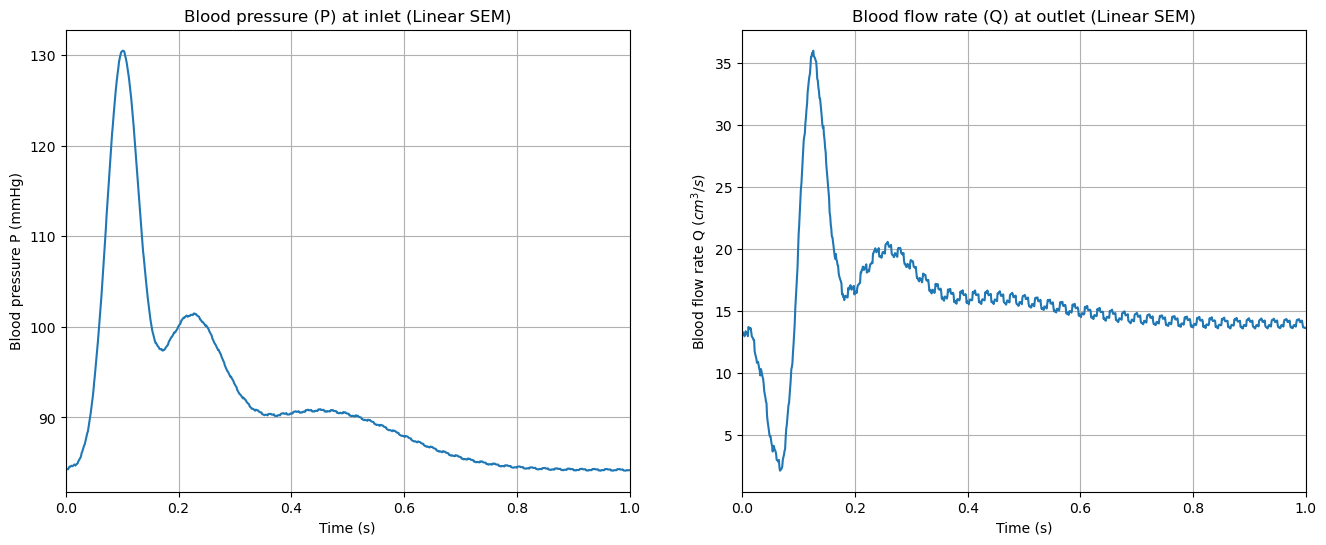

In [9]:
def sem_fft_ifft(N=1000, inlet_flow=inlet_flow, outlet_pressure=outlet_pressure):
    """
    SEM solver
        applies time domain boundary conditions to inlet flow and outlet pressure
        uses FFT to tranform inlet flow and outlet pressure from the time domain to the frequency domain
        computes the exact dynamic stiffness matrix for given frequency in the frequency domain
        applies IFFT to obtain inlet pressure and outlet flow in the time domain

    Parameters:
    -----
    N : int
        number of time steps
    inlet_flow : function
        defaults to physiologic inlet flow waveform q(0,t)
    outlet_pressure : function
        defaults to physiologic outlet pressure waveform p(L,t)
        
    Returns:
    -----
    t_lin : 1D array
        timesteps for linear SEM
    qint : 1D array
        inlet flow, subject to given BC
    pintifft : 1D array
        (solved) inlet pressure, transformed back into the time domain by IFFT
    qoutifft : 1D array
        (solved) outlet flow, transformed back into the time domain by IFFT
    poutt : 1D array
        outlet pressure, subject to given BC
    """

    # Time grid stuff 
    T = 1.0
    t = numpy.linspace(0.0, T, N, endpoint=False)
    dt = t[1] - t[0]
    

    # Time domain BCs: q_in and p_out
    qint = inlet_flow(t, params)
    poutt = outlet_pressure(t, params)

    
    # Apply FFT to inlet flow and outlet pressure
    qin_fft=numpy.fft.fft(qint)
    pout_fft=numpy.fft.fft(poutt)

    freq=numpy.fft.fftfreq(N, dt)
    omega=2*numpy.pi*freq

    # Spectral unknowns: p_in and q_out
    pin_fft = numpy.zeros(N, dtype=complex)
    qout_fft = numpy.zeros(N, dtype=complex)

    for n, w in enumerate(omega): 
        if abs(w) < 1e-12:
            # At steady state (ω=0), q should be constant along the vessel
            qout_fft[n] = qin_fft[n]  # conservation of mass
            
            # The pressure drop is determined by viscous resistance
            #   for Poiseuille flow in a pipe: Δp = R_flow * q
            #   where R_flow = (8 * μ * L) / (π * R^4)
            
            R_vessel = numpy.sqrt(A0 / numpy.pi)  # radius
            mu_visc = rho * nu  # dynamic viscosity
            
            # Poiseuille resistance
            R_flow = (8 * mu_visc * L) / (numpy.pi * R_vessel**4)
            
            # Pressure drop from inlet to outlet
            pin_fft[n] = pout_fft[n] + R_flow * qin_fft[n]
            continue

        # S(w) entries
        S = sem_dynam_stiffness(w, params)
        S11 = S[0,0]
        S12 = S[0,1]
        S21 = S[1,0]
        S22 = S[1,1]
        qin = qin_fft[n]
        pout = pout_fft[n]
        pin = (qin - S12 * pout) / S11
        pin_fft[n] = pin
        qout = -S21 * pin - S22 * pout
        qout_fft[n] = qout


    # Inverse FFT for same variables as above
    pintifft= numpy.fft.ifft(pin_fft).real
    qoutifft= numpy.fft.ifft(qout_fft).real

    
    return t, qint, pintifft, qoutifft, poutt

t_lin, qint, pintifft, qoutifft, poutt = sem_fft_ifft()


# Unit conversions for plotting (to match the paper)
pin_mmHg  = pintifft / 133.322
qout_cm3s = qoutifft * 1e6

fig = plt.figure(figsize=(16, 6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(t_lin, pin_mmHg)
axes.set_xlabel('Time (s)')
axes.set_ylabel(r'Blood pressure P (mmHg)')
axes.set_title('Blood pressure (P) at inlet (Linear SEM)')
axes.set_xlim(0.,1.)
axes.grid()

axes = fig.add_subplot(1, 2, 2)
axes.plot(t_lin, qout_cm3s)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Blood flow rate Q ($cm^{3}/s$)')
axes.set_title('Blood flow rate (Q) at outlet (Linear SEM)')
axes.set_xlim(0.,1.)
axes.grid()

plt.show()

**Test 1**: Here we show a test using $\mathbf{S}(\omega) = \mathbf{I}$ to validate the frequency-domain implementation.

In [10]:
def sem_fft_ifft_test():
    """
    Verifies the linear SEM solver by considering S(w) = I
    """

    # Time grid stuff
    T = 1.0
    N = 2048
    t = numpy.linspace(0.0, T, N, endpoint=False)
    dt = t[1] - t[0]


    # Time domain boundary conditions
    qint = inlet_flow(t, params)
    poutt = outlet_pressure(t, params)

    # FFT to q_in and p_out
    qin_fft = numpy.fft.fft(qint)
    pout_fft = numpy.fft.fft(poutt)

    freq = numpy.fft.fftfreq(N, dt)
    omega = 2 * numpy.pi * freq

    # Spectral unknowns p_in and q_out
    pin_fft = numpy.zeros(N, dtype=complex)
    qout_fft = numpy.zeros(N, dtype=complex)

    # Frequency domain solve
    for n, w in enumerate(omega):

        # Direct handling of the zero frequency mode
        if abs(w) < 1e-12:
            pin_fft[n] = qin_fft[n]
            qout_fft[n] = -pout_fft[n]
            continue

        # Identity dynamic stiffness matrix for testing
        S = numpy.eye(2, dtype=complex)

        S11 = S[0, 0]
        S12 = S[0, 1]
        S21 = S[1, 0]
        S22 = S[1, 1]

        qin = qin_fft[n]
        pout = pout_fft[n]

        # Solve for p_in and q_out in spectral space
        pin = (qin - S12 * pout) / S11
        pin_fft[n] = pin

        qout = -S21 * pin - S22 * pout
        qout_fft[n] = qout

        # Reference calculation for direct mapping check
        #   dp = numpy.array([pin_fft[n], pout_fft[n]], complex)
        #   dq = S @ dp
        #   qin_fft[n] = dq[0]
        #   qout_fft[n] = -dq[1]

    # IFFT to recover time domain fields
    pintifft = numpy.fft.ifft(pin_fft).real
    qoutifft = numpy.fft.ifft(qout_fft).real

    return t, qint, pintifft, qoutifft, poutt


# Run the test SEM evaluation
t, qint, pintifft, qoutifft, poutt = sem_fft_ifft_test()

# Absolute errors
err_in = numpy.max(numpy.abs(pintifft - qint))
err_out = numpy.max(numpy.abs(qoutifft + poutt))

# Relative errors
rel_in = err_in / numpy.max(numpy.abs(qint))
rel_out = err_out / numpy.max(numpy.abs(poutt))

# Tolerances
atol = 1e-10
rtol = 1e-8

# Assertion tests
assert (err_in < atol) or (rel_in < rtol), (
    f"Inlet error too large: abs={err_in}, rel={rel_in}"
)

assert (err_out < atol) or (rel_out < rtol), (
    f"Outlet error too large: abs={err_out}, rel={rel_out}"
)

print("inlet abs/rel error:", err_in, rel_in)
print("outlet abs/rel error:", err_out, rel_out)

inlet abs/rel error: 1.3552527156068805e-20 5.212510444641848e-16
outlet abs/rel error: 1.0913936421275139e-11 6.297037029652408e-16


**Test 2**: We set the inlet flow rate and outlet pressure (boundary conditions) to simple sinusoidal waves to verify that our SEM is behaving as expected.

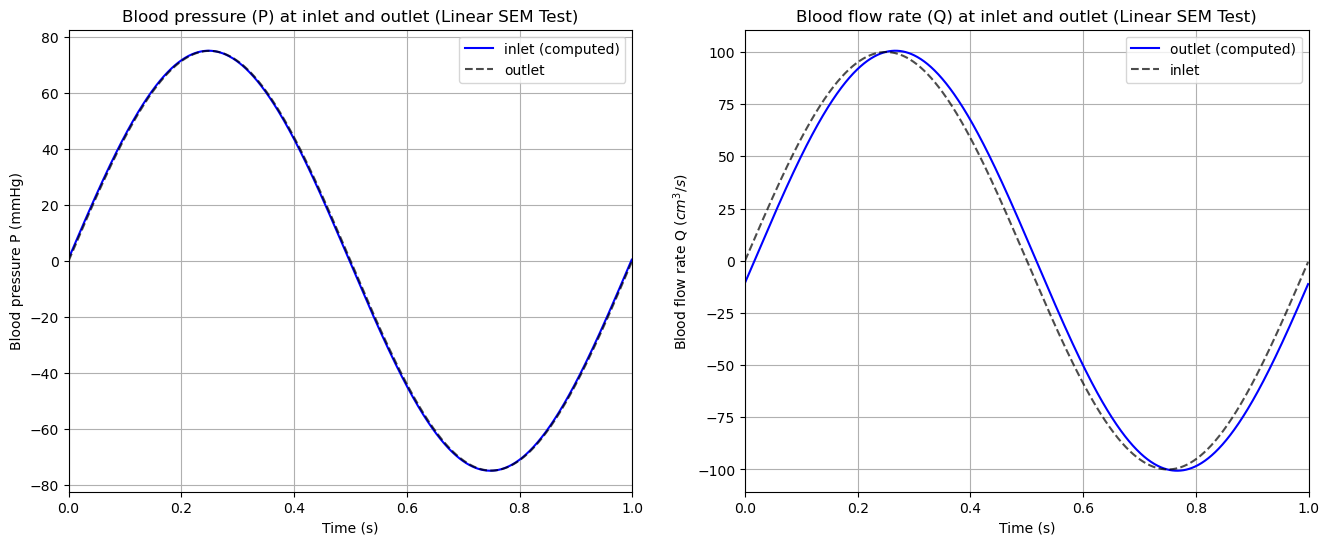

In [11]:
# Define simple sinusoidal test signals (with realistic amplitudes)
def inlet_flow_sin(t, params):
    return 0.0001 * numpy.sin(2 * numpy.pi * t)  # q_in = sin(2πt)
    # return numpy.sin(2*numpy.pi*t)

def outlet_pressure_sin(t, params):
    return 10000 * numpy.sin(2 * numpy.pi * t)  # p_out = cos(2πt)
    # return numpy.zeros_like(t)

t_sin, qint_sin, pintifft_sin, qoutifft_sin, poutt_sin = sem_fft_ifft(inlet_flow=inlet_flow_sin, outlet_pressure=outlet_pressure_sin)


# Unit conversions for plotting
pin_mmHg_sin  = pintifft_sin / 133.322
pout_mmHg_sin = poutt_sin / 133.322
qin_cm3s_sin = qint_sin * 1e6
qout_cm3s_sin = qoutifft_sin * 1e6

fig = plt.figure(figsize=(16, 6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(t_sin, pin_mmHg_sin, 'b-', label='inlet (computed)')
axes.plot(t_sin, pout_mmHg_sin, 'k--', alpha=0.7, label='outlet')
axes.set_xlabel('Time (s)')
axes.set_ylabel(r'Blood pressure P (mmHg)')
axes.set_title('Blood pressure (P) at inlet and outlet (Linear SEM Test)')
axes.set_xlim(0.,1.)
axes.legend(loc='best')
axes.grid()

axes = fig.add_subplot(1, 2, 2)
axes.plot(t_sin, qout_cm3s_sin, 'b-', label='outlet (computed)')
axes.plot(t_sin, qin_cm3s_sin, 'k--', alpha=0.7, label='inlet')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Blood flow rate Q ($cm^{3}/s$)')
axes.set_title('Blood flow rate (Q) at inlet and outlet (Linear SEM Test)')
axes.set_xlim(0.,1.)
axes.legend(loc='best')
axes.grid()

plt.show()

The sinusoidal outputs show no numerical instabilities, indicating that the FFT/IFFT transformations were implemented correctly, that the frequency-domain solutions were numerically stable, and that the matrix inversions were well-conditioned. Given smooth sinusoidal inputs (BCs), the solver produces smooth periodic outputs, which is expected for a linear system. Overall, the SEM solver produces physiologically plausible results for a simple sinusoidal test case.

### 1.2 Nonlinear SEM (Anjali Prasad)

After demonstrating a linear SEM, we consider the nonlinear case in which the forcing term $f_{NL}$ in the time domain is based on a quadratic convective term $q^2$.

We keep the same formulation for the physical parameters, coefficient matrices in the time domain and frequency domain, wavenumbers that solve the dispersion relation, and exact dynamic stiffness matrix relating $\bar{p} = \begin{Bmatrix} p_{in} \\ p_{out} \end{Bmatrix}$ and $\bar{q} = \begin{Bmatrix} q_{in} \\ q_{out} \end{Bmatrix}$. We create a new function that will compute the nonlinear forcing term in the time domain based on $p(t), q(t)$.

In [12]:
def nonlinear_forcing_time(p_t, q_t, params):
    """
    Compute nonlinear forcing term f_NL(t) in time domain based on p(t), q(t)
    Corresponds to the nonlinear terms on the RHS of momentum eq
    We use simplified nonlinear terms from Eq. 15 in Lee and Jang (2012)

    Parameters:
    -----
    p_t : (2,1) array
        vector representing blood pressure at inlet and outlet
    q_t : (2,1) array
        vector representing blood flow rate at inlet and outlet
    params : dict
        physical and model parameters

    Returns:
    -----
    fNL_vec : (2,1) array
        vector representing nonlinear forcing term in time-domain governing equations
    """

    A0 = params['A0']
    Qd = params['Qd']
    gamma = params['gamma']
    theta = params['theta']

    # Approximate nonlinear forcing as gamma * theta * A0^{-1} * Qd * q_t^2 (dominant convective term)
    fNL = gamma * theta * A0**(-1) * Qd * q_t**2

    # Return nonlinear forcing vector: both components nonzero (for demonstration)
    #   assign the same nonlinear forcing to both pressure and flow components
    fNL_vec = numpy.zeros_like(p_t)
    fNL_vec[:] = fNL
    return fNL_vec

Using the previusly defined functions as well as the new nonlinear forcing term, we create a nonlinear SEM based on AFT iteration. We run the solver and plot the computed solutions.

In [13]:
def nonlinear_sem_aft(params, T=1.0, N=1024, max_iter=10, 
                      inlet_flow=inlet_flow, outlet_pressure=outlet_pressure, tol=1e-6):
    """
    Solve nonlinear spectral element model using alternating frequency-time (AFT) method
    
    Parameters:
    -----
    params : dict
        physical and model parameters
    T : float
        total time period (s)
    N : int
        number of time samples (power of 2 for FFT)
    max_iter : int
        max number of nonlinear iterations
    inlet_flow : function
        defaults to physiologic inlet flow waveform q(0,t)
    outlet_pressure: function
        defaults to physiologic outlet pressure waveform p(L,t)
    tol : float
        convergence tolerance for nonlinear forcing
        
    Returns:
    -----
    t : 1D array
        time vector
    q_in_t : 1D array
        inlet flow rate time history (given BC)
    p_in_t : 1D array
        inlet pressure time history (computed)
    q_out_t : 1D array
        outlet flow rate time history (computed)
    p_out_t : 1D array 
        outlet pressure time history (given BC)
    """
    
    L = params['L']
    dt = T / N
    t_nl = numpy.linspace(0, T, N, endpoint=False)


    q_in_t = inlet_flow(t_nl, params)
    p_out_t = outlet_pressure(t_nl, params)

    # FFT frequencies and angular frequencies
    freq = numpy.fft.fftfreq(N, dt)
    omega = 2.0 * numpy.pi * freq

    # Initialize spectral unknowns for inlet pressure and outlet flow rate
    p_in_fft = numpy.zeros(N, dtype=complex)
    q_out_fft = numpy.zeros(N, dtype=complex)

    # Initial guess for nonlinear forcing in frequency domain (zero)
    fNL_fft = numpy.zeros((2, N), dtype=complex)  # now 2 components

    # Precompute FFT of BCs
    q_in_fft = numpy.fft.fft(q_in_t)
    p_out_fft = numpy.fft.fft(p_out_t)

    # AFT iteration loop
    for iteration in range(max_iter):
        p_in_fft_old = p_in_fft.copy()
        q_out_fft_old = q_out_fft.copy()

        for n, w in enumerate(omega):
            if abs(w) < 1e-12:
                # At steady state (ω=0), q should be constant along the vessel
                q_out_fft[n] = q_in_fft[n]  # conservation of mass
                
                # The pressure drop is determined by viscous resistance
                #   for Poiseuille flow in a pipe: Δp = R_flow * q
                #   where R_flow = (8 * μ * L) / (π * R^4)
                
                R_vessel = numpy.sqrt(A0 / numpy.pi)  # radius
                mu_visc = rho * nu  # dynamic viscosity
                
                # Poiseuille resistance
                R_flow = (8 * mu_visc * L) / (numpy.pi * R_vessel**4)
                
                # Pressure drop from inlet to outlet
                p_in_fft[n] = p_out_fft[n] + R_flow * q_in_fft[n]
                continue

            # Compute dynamic stiffness matrix S(w)
            S = sem_dynam_stiffness(w, params)

            # Extract matrix entries
            S11, S12 = S[0, 0], S[0, 1]
            S21, S22 = S[1, 0], S[1, 1]

            # Nonlinear forcing components in frequency domain (both components nonzero)
            fNL1 = fNL_fft[0, n]
            fNL2 = fNL_fft[1, n]

            qin = q_in_fft[n]
            pout = p_out_fft[n]

            # Solve for p_in
            p_in_fft[n] = (qin + 0.0 + fNL1 - S12 * pout) / S11

            # Compute q_out
            q_out_fft[n] = -S21 * p_in_fft[n] - S22 * pout + 0.0 + fNL2

        # Inverse FFT to time domain to update nonlinear forcing
        p_in_t = numpy.fft.ifft(p_in_fft).real
        q_out_t = numpy.fft.ifft(q_out_fft).real

        # Compute nonlinear forcing in time domain using updated p_in_t and q_out_t
        fNL_t = nonlinear_forcing_time(p_in_t, q_out_t, params)

        # FFT nonlinear forcing for next iteration (assign to both components)
        fNL_fft[0, :] = numpy.fft.fft(fNL_t)  # first component
        fNL_fft[1, :] = numpy.fft.fft(fNL_t)  # second component

        # Check convergence (max change in p_in_fft)
        err = numpy.max(numpy.abs(p_in_fft - p_in_fft_old))
        print(f"Iteration {iteration+1}, max change in p_in_fft: {err:.3e}")
        if err < tol:
            print("Converged!")
            break

    # Return time and time-domain signals
    return t_nl, q_in_t, p_in_t, q_out_t, p_out_t

Iteration 1, max change in p_in_fft: 2.507e+07
Iteration 2, max change in p_in_fft: 0.000e+00
Converged!


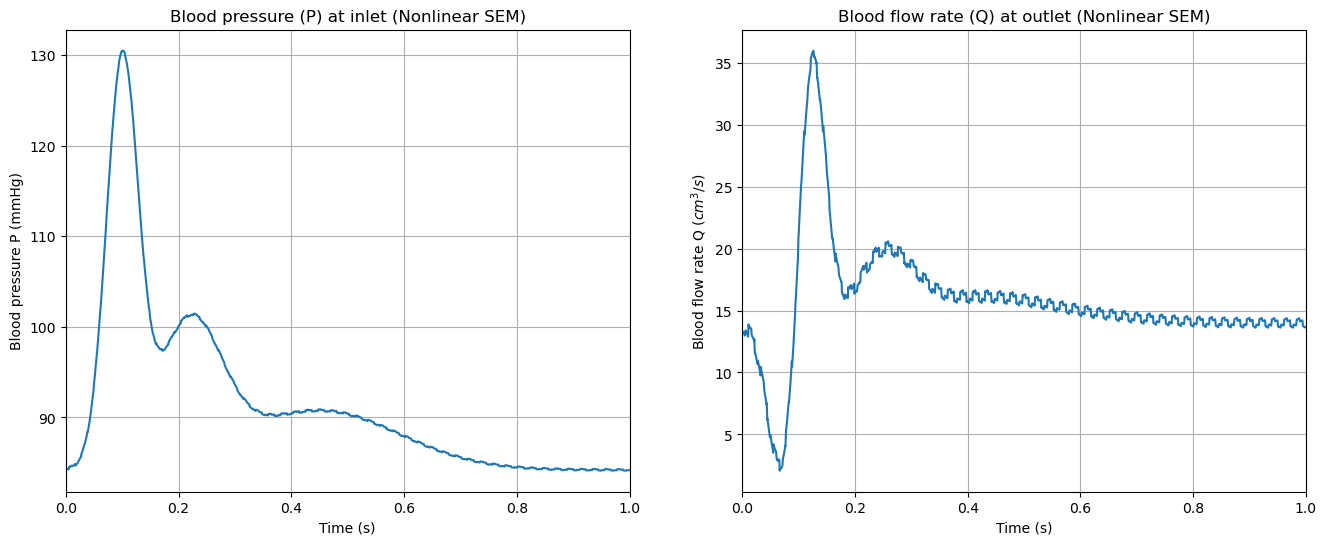

In [14]:
# Run nonlinear SEM solver
t_nl, q_in_t, p_in_t, q_out_t, p_out_t = nonlinear_sem_aft(params, T=1.0, N=2048, max_iter=20, tol=1e-7)


# Convert units for plotting
p_in_mmHg = p_in_t / 133.322  # Pa to mmHg
q_out_cm3s = q_out_t * 1e6  # m^3/s to cm^3/s


# Plot results to show nonlinear effects
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(t_nl, p_in_mmHg)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Blood pressure P (mmHg)')
axes.set_title('Blood pressure (P) at inlet (Nonlinear SEM)')
axes.grid()
axes.set_xlim(0, 1)

axes = fig.add_subplot(1, 2, 2)
axes.plot(t_nl, q_out_cm3s)
axes.set_xlabel('Time (s)')
axes.set_ylabel(r'Blood flow rate Q ($cm^3/s$)')
axes.set_title('Blood flow rate (Q) at outlet (Nonlinear SEM)')
axes.grid()
axes.set_xlim(0, 1)

plt.show()

**Test 1**: Similarly, we validate the frequency-domain implementation in the nonlinear SEM using $\mathbf{S}(\omega)=\mathbf{I}$.

In [15]:
def nonlinear_sem_fft_ifft_test():
    """
    Verifies the nonlinear SEM solver by considering S(w) = I
    """
    
    T = 1.0
    N = 2048
    t_test = numpy.linspace(0.0, T, N, endpoint=False)
    dt = t[1] - t[0]

    qint = inlet_flow(t_test, params)
    poutt = outlet_pressure(t_test, params)

    qin_fft = numpy.fft.fft(qint)
    pout_fft = numpy.fft.fft(poutt)

    freq = numpy.fft.fftfreq(N, dt)
    omega = 2 * numpy.pi * freq

    pin_fft = numpy.zeros(N, dtype=complex)
    qout_fft = numpy.zeros(N, dtype=complex)

    # For nonlinear SEM test, we use nonlinear spectral element dynamic stiffness matrix
    for n, w in enumerate(omega):
        if abs(w) < 1e-12:
            pin_fft[n] = qin_fft[n]
            qout_fft[n] = -pout_fft[n]
            continue

        # identity dynamic stiffness matrix for testing
        S = numpy.eye(2, dtype=complex)

        S11 = S[0, 0]
        S12 = S[0, 1]
        S21 = S[1, 0]
        S22 = S[1, 1]

        qin = qin_fft[n]
        pout = pout_fft[n]

        # solve for pin and qout in spectral space
        pin = (qin - S12 * pout) / S11
        pin_fft[n] = pin

        qout = -S21 * pin - S22 * pout
        qout_fft[n] = qout

    

    pintifft = numpy.fft.ifft(pin_fft).real
    qoutifft = numpy.fft.ifft(qout_fft).real

    return t_test, qint, pintifft, qoutifft, poutt


# Run nonlinear SEM solver
t_test, qint, pintifft, qoutifft, poutt = nonlinear_sem_fft_ifft_test()

# Absolute errors
err_in = numpy.max(numpy.abs(pintifft - qint))
err_out = numpy.max(numpy.abs(qoutifft + poutt))

# Relative errors
rel_in = err_in / numpy.max(numpy.abs(qint))
rel_out = err_out / numpy.max(numpy.abs(poutt))

# Tolerances
atol = 1e-10
rtol = 1e-8

# assertion tests
assert (err_in < atol) or (rel_in < rtol), (
    f"Inlet error too large: abs={err_in}, rel={rel_in}"
)

assert (err_out < atol) or (rel_out < rtol), (
    f"Outlet error too large: abs={err_out}, rel={rel_out}"
)

print("Nonlinear inlet abs/rel error:", err_in, rel_in)
print("Nonlinear outlet abs/rel error:", err_out, rel_out)

Nonlinear inlet abs/rel error: 1.3552527156068805e-20 5.212510444641848e-16
Nonlinear outlet abs/rel error: 1.0913936421275139e-11 6.297037029652408e-16


**Test 2**: Again, we pass simple sinusoidal wave functions into the solver to determine if it is behaving as expected.

Iteration 1, max change in p_in_fft: 1.025e+07
Iteration 2, max change in p_in_fft: 0.000e+00
Converged!


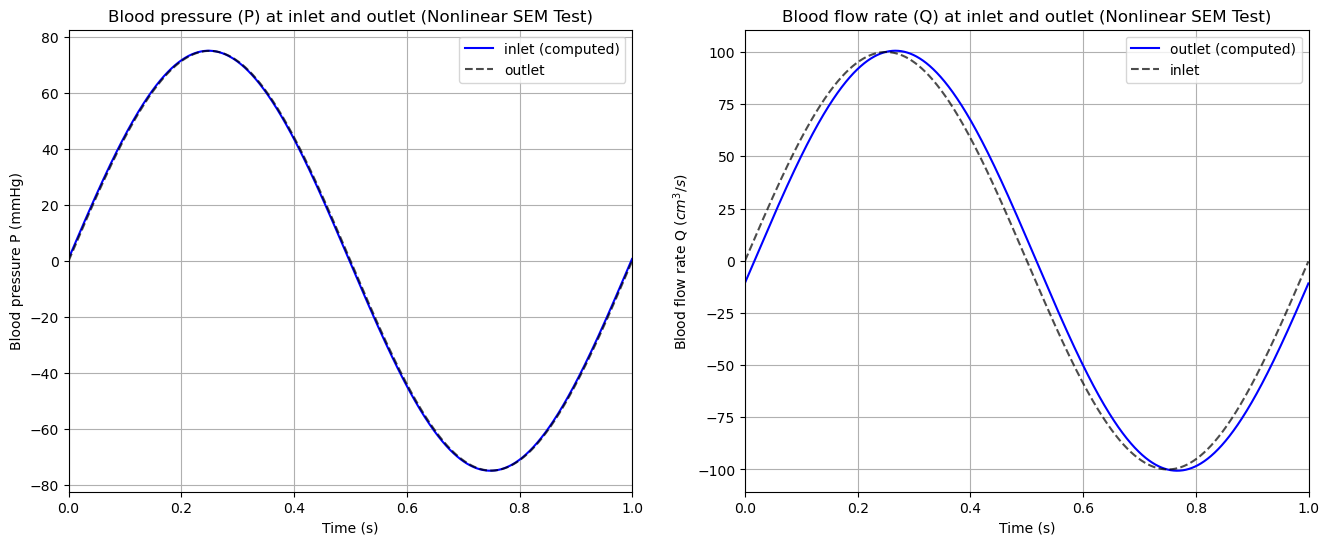

In [16]:
t_nl_sin, q_in_t_sin, p_in_t_sin, q_out_t_sin, p_out_t_sin = nonlinear_sem_aft(params, T=1.0, N=2048, max_iter=20, 
                                                                               inlet_flow=inlet_flow_sin, outlet_pressure=outlet_pressure_sin,
                                                                               tol=1e-7)

# Convert units for plotting
p_in_mmHg_sin = p_in_t_sin / 133.322  # Pa to mmHg
p_out_mmHg_sin = p_out_t_sin / 133.322
q_out_cm3s_sin = q_out_t_sin * 1e6  # m^3/s to cm^3/s
q_in_cm3s_sin = q_in_t_sin * 1e6


# Plot results to show nonlinear effects
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(t_nl_sin, p_in_mmHg_sin, 'b-', label='inlet (computed)')
axes.plot(t_nl_sin, p_out_mmHg_sin, 'k--', alpha=0.7, label='outlet')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Blood pressure P (mmHg)')
axes.set_title('Blood pressure (P) at inlet and outlet (Nonlinear SEM Test)')
axes.grid()
axes.legend(loc='best')
axes.set_xlim(0, 1)

axes = fig.add_subplot(1, 2, 2)
axes.plot(t_nl_sin, q_out_cm3s_sin, 'b-', label='outlet (computed)')
axes.plot(t_nl_sin, q_in_cm3s_sin, 'k--', alpha=0.7, label='inlet')
axes.set_xlabel('Time (s)')
axes.set_ylabel(r'Blood flow rate Q ($cm^3/s$)')
axes.set_title('Blood flow rate (Q) at inlet and outlet (Nonlinear SEM Test)')
axes.grid()
axes.legend(loc='best')
axes.set_xlim(0, 1)

plt.show()

We see similar results when passing simple sinusoidal wave function BCs through our linear and our nonlinear SEM. There are no numerical oscillations, and the waveforms are smooth and bounded.

### Below are the key differences and modifications made for the nonlinear SEM solver compared to the linear SEM:
The nonlinear SEM solver extends the linear SEM by incorporating nonlinear terms that depend on the solution itself. In the linear SEM, we previously set the nonlinear forcing term $ \mathbf{f}_{NL} $ to be zero. In the nonlinear SEM, we have a nonzero $ \mathbf{f}_{NL}(p, q) $ that is proportional to dominant nonlinear convective term $ q(t)^2 $. We also set the velocity profile parameter $ \theta $ to a small nonzero value (e.g., $ \theta = 1 \times 10^{-3} $) to introduce velocity profile damping effects, which are part of the nonlinear behavior. 

Unlike in the linear case, we must take an iterative approach in the nonlinear SEM because the nonlinear forcing term depends on the unknown pressure and flow rate fields $ p(t) $ and $ q(t) $. The AFT iteration enables handling these nonlinearities by alternating between time and frequency domains, updating the nonlinear forcing term iteratively. This approach allows the spectral element method to solve nonlinear blood flow problems in viscoelastic (elastic in our case) vessels efficiently and accurately, capturing nonlinear wave propagation effects that the linear SEM cannot.

Additionally, we generate plots that compare solutions for the linear and nonlinear SEMs.

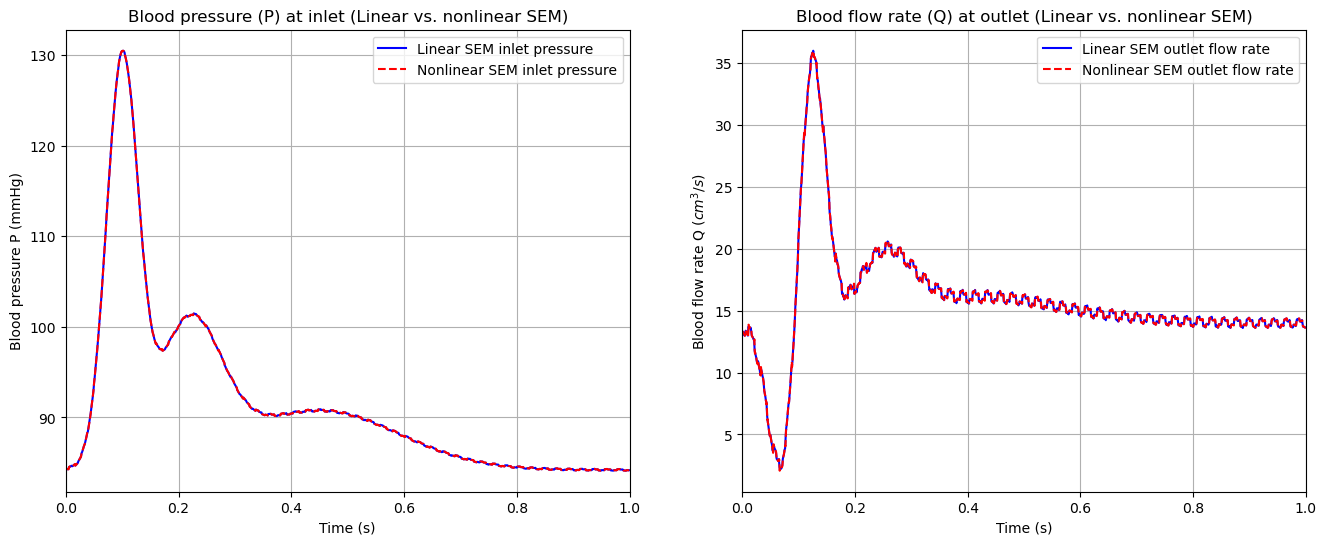

In [17]:
fig = plt.figure(figsize=(16,6))

# Case 1: blood pressure at inlet
axes = fig.add_subplot(1, 2, 1)
axes.plot(t_lin, pin_mmHg, 'b-', label='Linear SEM inlet pressure')  # linear SEM solution
axes.plot(t_nl, p_in_mmHg, 'r--', label='Nonlinear SEM inlet pressure')  # nonlinear SEM solution
axes.set_xlabel('Time (s)')
axes.set_ylabel('Blood pressure P (mmHg)')
axes.set_title('Blood pressure (P) at inlet (Linear vs. nonlinear SEM)')
axes.grid()
axes.set_xlim(0, 1)
axes.legend(loc='best')

# Case 2: blood flow rate at outlet
axes = fig.add_subplot(1, 2, 2)
axes.plot(t_lin, qout_cm3s, 'b-', label='Linear SEM outlet flow rate')  # linear SEM solution
axes.plot(t_nl, q_out_cm3s, 'r--', label='Nonlinear SEM outlet flow rate')  # nonlinear SEM solution
axes.set_xlabel('Time (s)')
axes.set_ylabel(r'Blood flow rate Q ($cm^3/s$)')
axes.set_title('Blood flow rate (Q) at outlet (Linear vs. nonlinear SEM)')
axes.grid()
axes.set_xlim(0, 1)
axes.legend(loc='best')

plt.show()

### SEM Results

From these plots, we observe that the linear and nonlinear solutions for inlet pressure and outlet flow rate are visually very similar. This may be due to simplications other than linearization that we assumed in the derivation of our time-domain and frequency-domain governing equations.

Both the linear and nonlinear FEM achieve absolute errors around machine epsilon at the inlet and outlet when we verified the methods (by setting the dynamic stiffness equation $\mathbf{S}(\omega) = \mathbf{I}$. Next, we turn to other numerical methods to evaluate the robustness of our SEM.

## 2. FEM (Zala Bhan, Athena Ke)

As mentioned above, we discretize the linearized governing equations in space and time and apply the finite element method (FEM) to solve for inlet pressure and outlet flow rate. We form the global system by defining element block contributions using a stiffness matrix, advection matrix, and mass matrix and combining with the given coefficient matrices.

In [18]:
def fem_time_domain(params, N_elem=40, N_time=1000, T_period=1.0, return_spatial=False):
    """
    (time-domain) FEM using backward Euler time integration that:
        discretizes space as a system of ODEs in time
        time-steps through the problem
        solves the linearized time-domain governing equations: C ∂u/∂t + D ∂²u/∂x² + A ∂u/∂x + K u = 0

    Parameters:
    -----
    params : dict
        physical and model parameters
    N_elem : int
        number of elements for spatial discretization
    N_time : int
        number of time steps for backward Euler time integration
    T_period : float
        total time period (s)
    return_spatial : Bool
        returns spatial solution if True

    Returns:
    -----
    t : 1D array
        time steps
    q_in_t : 1D array
        inlet flow rate
    p_in_t : 1D array
        inlet pressure (computed)
    p_out_t : 1D array
        outlet pressure
    q_out_t : 1D array
        outlet flow rate (computed)
    """
    
    L_vessel = params['L']
    kappa = params['kappa']
    nu = params['nu']
    c2 = params['c2']
    u_vel = params['u']
    alpha = params['alpha']
    
    # Spatial discretization
    h_elem = L_vessel / N_elem
    x_nodes = numpy.linspace(0, L_vessel, N_elem + 1)
    n_nodes = N_elem + 1
    n_dof = 2 * n_nodes
    
    # Time discretization
    t = numpy.linspace(0.0, T_period, N_time)
    dt = t[1] - t[0]
    
    # Boundary conditions (directly in time domain)
    q_in_t = inlet_flow(t, params)
    p_out_t = outlet_pressure(t, params)
    
    # Element matrices
    K_elem = (1.0 / h_elem) * numpy.array([[1., -1.], [-1., 1.]])
    A_elem = 0.5 * numpy.array([[-1., 1.], [-1., 1.]])
    M_elem = (h_elem / 6.0) * numpy.array([[2., 1.], [1., 2.]])
    
    # PDE coefficient matrices (REAL, not complex)
    C_mat = numpy.array([[1./kappa, 0.], [0., 1.]])
    D_mat = numpy.array([[0., 0.], [0., -nu]])
    A_mat = numpy.array([[0., 1.], [c2, u_vel]])
    K_mat = numpy.array([[0., 0.], [0., alpha]])
    
    # Assemble global matrices
    M_global = numpy.zeros((n_dof, n_dof))
    K_global = numpy.zeros((n_dof, n_dof))
    
    for e in range(N_elem):
        node_i, node_j = e, e + 1
        local_dofs = [2*node_i, 2*node_i+1, 2*node_j, 2*node_j+1]
        
        M_e = numpy.zeros((4, 4))
        K_e = numpy.zeros((4, 4))
        
        for a in range(2):
            for b in range(2):
                kab, aab, mab = K_elem[a,b], A_elem[a,b], M_elem[a,b]
                M_e[2*a:2*a+2, 2*b:2*b+2] += mab * C_mat
                K_e[2*a:2*a+2, 2*b:2*b+2] += -kab * D_mat + aab * A_mat + mab * K_mat
        
        for ii in range(4):
            for jj in range(4):
                M_global[local_dofs[ii], local_dofs[jj]] += M_e[ii, jj]
                K_global[local_dofs[ii], local_dofs[jj]] += K_e[ii, jj]
    
    # Initialize
    U = numpy.zeros((N_time, n_dof))
    for i in range(n_nodes):
        U[0, 2*i] = p_out_t[0]
        U[0, 2*i+1] = q_in_t[0]
    
    # Time-stepping: Backward Euler (implicit, stable)
    A_system = M_global / dt + K_global
    
    for n in range(N_time - 1):
        rhs = (M_global / dt) @ U[n, :]
        A_bc = A_system.copy()
        
        # BC: q(0) = q_in
        A_bc[1, :] = 0
        A_bc[1, 1] = 1
        rhs[1] = q_in_t[n+1]
        
        # BC: p(L) = p_out
        A_bc[2*N_elem, :] = 0
        A_bc[2*N_elem, 2*N_elem] = 1
        rhs[2*N_elem] = p_out_t[n+1]
        
        U[n+1, :] = numpy.linalg.solve(A_bc, rhs)
    
    p_in_t = U[:, 0]
    q_out_t = U[:, 2*N_elem+1]
    
    if return_spatial:
        p_all = numpy.array([U[:, 2*i] for i in range(n_nodes)]).T
        q_all = numpy.array([U[:, 2*i+1] for i in range(n_nodes)]).T
        return t, x_nodes, q_in_t, p_in_t, p_out_t, q_out_t, p_all, q_all
    
    return t, q_in_t, p_in_t, p_out_t, q_out_t

## 3. Shooting Method (Zala Bhan)

We apply the shooting method to convert the boundary value problem (BVP) to initial value problems (IVPs). We reformulate the second-order system as a first-order system:
$$\frac{d}{dx}\begin{bmatrix} p \\ q \end{bmatrix} = \begin{bmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{bmatrix} \begin{bmatrix} p \\ q \end{bmatrix}$$

We first solve the homogeneous IVP with conditions $p(0)=1, q(0)=0$. We then solve the particular IVP with $p(0)=0, q(0)=q_{in}$. Finally, we use superposition to satisfy the outlet boundary condition $p(L) = p_{out}$.

In [19]:
def solve_time_domain_shooting(params, N_x=100, N_time=1000, T_period=1.0, t_snapshot=0.1):
    """
    Time-domain shooting method that also returns spatial solution at t_snapshot

    Parameters:
    -----
    params : dict
        physical and model parameters
    N_x : int
        number of spatial steps
    N_time : int
        number of time steps
    T_period : float
        total time period (s)
    t_snapshot : float
        extract spatial solution at this time

    Returns:
    -----
    t_shoot : 1D array
        time steps
    x_grid : 1D array
        spatial mesh
    q_in_t : 1D array
        inlet flow rate
    p_in_t : 1D array
        inlet pressure (computed)
    p_out_t: 1D array
        outlet pressure
    q_out_t : 1D array
        outlet flow rate (computed)
    p_snapshot : 1D array
        spatial solution at t_snapshot
    q_snapshot : 1D array
        spatial solution at t_snapshot
    """
    
    L_vessel = params['L']
    kappa = params['kappa']
    nu = params['nu']
    c2 = params['c2']
    u_vel = params['u']
    alpha = params['alpha']
    
    t = numpy.linspace(0.0, T_period, N_time)
    dt = t[1] - t[0]
    x_grid = numpy.linspace(0, L_vessel, N_x)
    dx = x_grid[1] - x_grid[0]
    
    q_in_t = inlet_flow(t, params)
    p_out_t = outlet_pressure(t, params)
    
    C_mat = numpy.array([[1./kappa, 0.], [0., 1.]])
    A_mat = numpy.array([[0., 1.], [c2, u_vel]])
    K_mat = numpy.array([[0., 0.], [0., alpha]])
    K_eff = K_mat + C_mat / dt
    
    p_in_t = numpy.zeros(N_time)
    q_out_t = numpy.zeros(N_time)
    
    p_old = numpy.ones(N_x) * p_out_t[0]
    q_old = numpy.ones(N_x) * q_in_t[0]
    
    p_in_t[0] = p_out_t[0]
    q_out_t[0] = q_in_t[0]
    
    beta = 1.0 / (kappa * dt)
    gamma = 1.0 / dt + alpha
    denom = c2 + nu * beta
    
    # Storage for spatial snapshot
    idx_snapshot = numpy.argmin(numpy.abs(t - t_snapshot))
    p_snapshot = None
    q_snapshot = None
    
    for n in range(1, N_time):
        q_in = q_in_t[n]
        p_out = p_out_t[n]
        
        p_old_interp = interp1d(x_grid, p_old, kind='linear', fill_value='extrapolate')
        q_old_interp = interp1d(x_grid, q_old, kind='linear', fill_value='extrapolate')
        p_old_x = numpy.gradient(p_old, dx)
        p_old_x_interp = interp1d(x_grid, p_old_x, kind='linear', fill_value='extrapolate')
        
        def ode_system(x, y):
            p, q = y
            p_old_val = p_old_interp(x)
            q_old_val = q_old_interp(x)
            p_old_x_val = p_old_x_interp(x)
            
            dq_dx = beta * (p_old_val - p)
            dp_dx = (q_old_val / dt - gamma * q + u_vel * beta * (p - p_old_val) + nu * beta * p_old_x_val) / denom
            
            return [dp_dx, dq_dx]
        
        def shooting_residual(p0):
            y0 = [p0, q_in]
            sol = solve_ivp(ode_system, [0, L_vessel], y0, method='RK45',
                           dense_output=True, rtol=1e-10, atol=1e-12)
            if not sol.success:
                return 1e10
            return sol.sol(L_vessel)[0] - p_out
        
        p_low, p_high = p_out * 0.5, p_out * 1.5
        res_low, res_high = shooting_residual(p_low), shooting_residual(p_high)
        
        for _ in range(10):
            if res_low * res_high < 0:
                break
            p_low *= 0.8
            p_high *= 1.2
            res_low, res_high = shooting_residual(p_low), shooting_residual(p_high)
        
        try:
            if res_low * res_high < 0:
                p0_solution = brentq(shooting_residual, p_low, p_high, xtol=1e-10)
            else:
                p0_solution = p_in_t[n-1]
        except:
            p0_solution = p_in_t[n-1]
        
        y0 = [p0_solution, q_in]
        sol = solve_ivp(ode_system, [0, L_vessel], y0, method='RK45',
                       dense_output=True, rtol=1e-10, atol=1e-12)
        
        y_at_x = sol.sol(x_grid)
        p_new = y_at_x[0, :]
        q_new = y_at_x[1, :]
        
        p_in_t[n] = p_new[0]
        q_out_t[n] = q_new[-1]
        
        # Save snapshot
        if n == idx_snapshot:
            p_snapshot = p_new.copy()
            q_snapshot = q_new.copy()
        
        p_old = p_new.copy()
        q_old = q_new.copy()
        
        if n % 200 == 0:
            print(f"  Shooting: step {n}/{N_time}")
    
    return t, x_grid, q_in_t, p_in_t, p_out_t, q_out_t, p_snapshot, q_snapshot

### Validation 1: Spatial Distribution

We validate the FEM implementation by comparing the spatial distribution of pressure $|p(x)|$ and flow rate $|q(x)|$ against the shooting method (exact reference) at a test frequency of $f = 5$ Hz.

This plot demonstrates:
- FEM converges to the exact solution as mesh is refined ($N = 10, 20, 40$)
- All methods solve the same underlying physics
- FEM accurately captures the spatial variation along the vessel

Computing TD-Shooting reference solution...
  Shooting: step 200/500
  Shooting: step 400/500
Computing TD-FEM reference (N=80)...
Computing TD-FEM with N=10...
Computing TD-FEM with N=20...
Computing TD-FEM with N=4...


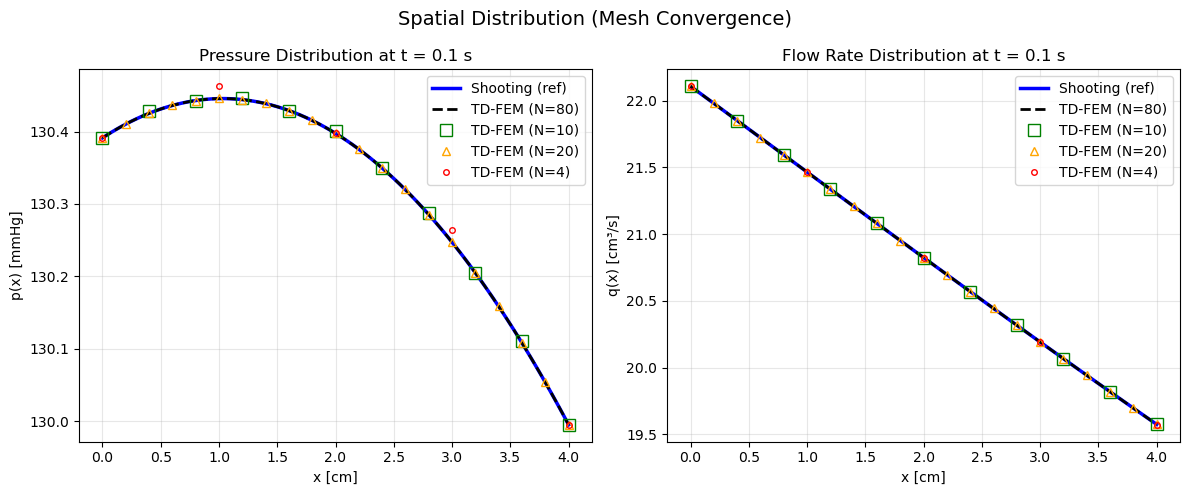

In [21]:
# SPATIAL DISTRIBUTION : Shows pressure and flow along vessel at peak systole (t = 0.1s)
# Compares FEM (various mesh sizes) vs Shooting reference

N_time = 500
t_snapshot = 0.1 

# Compute solutions
print("Computing TD-Shooting reference solution...")
t_shoot, x_shoot, _, _, _, _, p_shoot_spatial, q_shoot_spatial = solve_time_domain_shooting(
    params, N_x=100, N_time=N_time, t_snapshot=t_snapshot)

print("Computing TD-FEM reference (N=80)...")
t_ref, x_ref, _, _, _, _, p_ref_all, q_ref_all = fem_time_domain(
    params, N_elem=80, N_time=N_time, return_spatial=True)
idx_ref = numpy.argmin(numpy.abs(t_ref - t_snapshot))
p_ref = p_ref_all[idx_ref, :]
q_ref = q_ref_all[idx_ref, :]

# TD-FEM at different mesh resolutions
N_values_spatial = [10, 20, 4]
fem_solutions = []

for N in N_values_spatial:
    print(f"Computing TD-FEM with N={N}...")
    t_fem, x_fem, _, _, _, _, p_all, q_all = fem_time_domain(
        params, N_elem=N, N_time=N_time, return_spatial=True)
    idx = numpy.argmin(numpy.abs(t_fem - t_snapshot))
    fem_solutions.append((x_fem, p_all[idx, :], q_all[idx, :], N))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = ['green', 'orange', 'red']
markers = ['s', '^', 'o']

# Pressure
ax1 = axes[0]
ax1.plot(x_shoot * 100, p_shoot_spatial / 133.322, 'b-', linewidth=2.5, label='Shooting (ref)')
ax1.plot(x_ref * 100, p_ref / 133.322, 'k--', linewidth=2, label='TD-FEM (N=80)')
for i, (x_f, p_f, q_f, N) in enumerate(fem_solutions):
    ax1.plot(x_f * 100, p_f / 133.322, markers[i], color=colors[i],
             markersize=8-i*2, markerfacecolor='none', label=f'TD-FEM (N={N})')
ax1.set_xlabel('x [cm]')
ax1.set_ylabel('p(x) [mmHg]')
ax1.set_title(f'Pressure Distribution at t = {t_snapshot} s')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Flow
ax2 = axes[1]
ax2.plot(x_shoot * 100, q_shoot_spatial * 1e6, 'b-', linewidth=2.5, label='Shooting (ref)')
ax2.plot(x_ref * 100, q_ref * 1e6, 'k--', linewidth=2, label='TD-FEM (N=80)')
for i, (x_f, p_f, q_f, N) in enumerate(fem_solutions):
    ax2.plot(x_f * 100, q_f * 1e6, markers[i], color=colors[i],
             markersize=8-i*2, markerfacecolor='none', label=f'TD-FEM (N={N})')
ax2.set_xlabel('x [cm]')
ax2.set_ylabel('q(x) [cm³/s]')
ax2.set_title(f'Flow Rate Distribution at t = {t_snapshot} s')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Spatial Distribution (Mesh Convergence)', fontsize=14)
plt.tight_layout()
plt.show()


From the plots, we observe that the FEM and shooting method solvers converge to the same solution at a single moment in time. The FEM solutions with different meshes converge to the shooting method solution as the mesh becomes finer, which is as expected. The solutions are smooth and well-behaved.

### Validation 2: FEM Convergence

We verify the theoretical $O(h^2)$ convergence rate of linear finite elements by computing the error at the boundaries:
$$e_p = |p(0)_{FEM} - p(0)_{ref}|, \quad e_q = |q(L)_{FEM} - q(L)_{ref}|$$

for mesh sizes $N = 4, 8, 16, 32$ elements.

**Convergence Rate Calculation:**
$$\text{rate} = \frac{\log(e_{N/2}/e_N)}{\log(2)}$$

We limit to $N \leq 32$ to avoid the regime where errors plateau at machine precision.

Computing FEM with N=4...
Computing FEM with N=8...
Computing FEM with N=16...
Computing FEM with N=32...
Computing FEM with N=64...


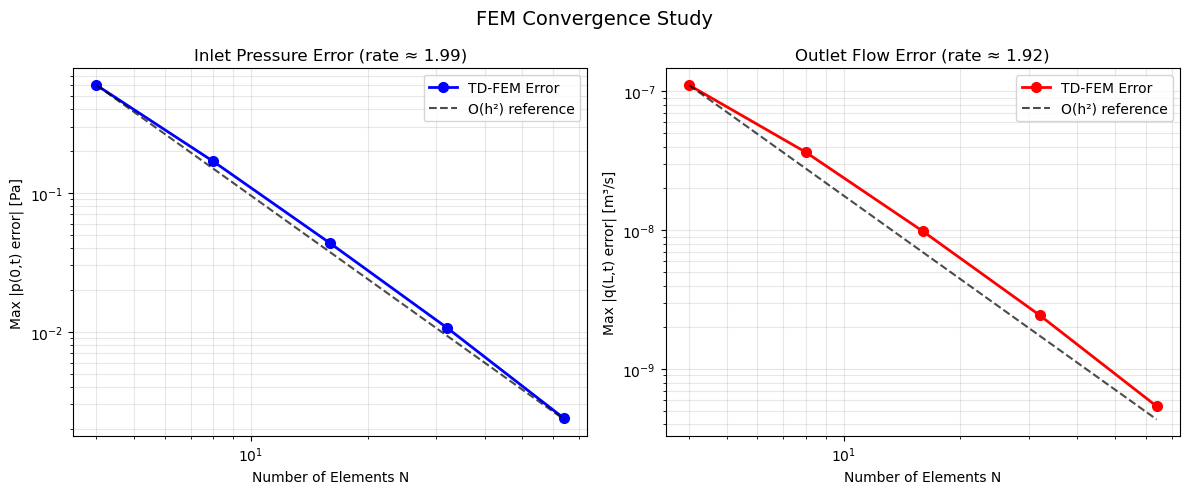


     N |   |p_err| [Pa] | |q_err| [m³/s] |   p rate |   q rate
-----------------------------------------------------------------
     4 |       5.98e-01 |       1.11e-07 |        — |        —
     8 |       1.68e-01 |       3.65e-08 |     1.83 |     1.61
    16 |       4.34e-02 |       9.84e-09 |     1.96 |     1.89
    32 |       1.07e-02 |       2.44e-09 |     2.02 |     2.01
    64 |       2.38e-03 |       5.40e-10 |     2.16 |     2.18


In [22]:
# FEM CONVERGENCE STUDY (clean convergence region only)

# Reference solution
t_ref, _, p_in_ref, _, q_out_ref = fem_time_domain(params, N_elem=160, N_time=1000)

# Compute errors for different N
N_values = [4, 8, 16, 32, 64]
p_errors = []
q_errors = []

for N in N_values:
    print(f"Computing FEM with N={N}...")
    t_fem, _, p_in_fem, _, q_out_fem = fem_time_domain(params, N_elem=N, N_time=1000)
    
    # Max error over cardiac cycle
    p_errors.append(numpy.max(numpy.abs(p_in_fem - p_in_ref)))
    q_errors.append(numpy.max(numpy.abs(q_out_fem - q_out_ref)))

# Compute convergence rates
p_rates = [numpy.log(p_errors[i-1]/p_errors[i]) / numpy.log(2) for i in range(1, len(N_values))]
q_rates = [numpy.log(q_errors[i-1]/q_errors[i]) / numpy.log(2) for i in range(1, len(N_values))]
avg_p_rate = numpy.mean(p_rates)
avg_q_rate = numpy.mean(q_rates)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Pressure error
ax1.loglog(N_values, p_errors, 'bo-', markersize=7, linewidth=2, label='TD-FEM Error')
ref_line = p_errors[0] * (numpy.array(N_values) / N_values[0])**(-2)
ax1.loglog(N_values, ref_line, 'k--', linewidth=1.5, alpha=0.7, label='O(h²) reference')
ax1.set_xlabel('Number of Elements N')
ax1.set_ylabel('Max |p(0,t) error| [Pa]')
ax1.set_title(f'Inlet Pressure Error (rate ≈ {avg_p_rate:.2f})')
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

# Flow error
ax2.loglog(N_values, q_errors, 'ro-', markersize=7, linewidth=2, label='TD-FEM Error')
ref_line_q = q_errors[0] * (numpy.array(N_values) / N_values[0])**(-2)
ax2.loglog(N_values, ref_line_q, 'k--', linewidth=1.5, alpha=0.7, label='O(h²) reference')
ax2.set_xlabel('Number of Elements N')
ax2.set_ylabel('Max |q(L,t) error| [m³/s]')
ax2.set_title(f'Outlet Flow Error (rate ≈ {avg_q_rate:.2f})')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.suptitle('FEM Convergence Study', fontsize=14)
plt.tight_layout()
plt.show()

# Print convergence table
print(f"\n{'N':>6} | {'|p_err| [Pa]':>14} | {'|q_err| [m³/s]':>14} | {'p rate':>8} | {'q rate':>8}")
print("-" * 65)
for i, N in enumerate(N_values):
    p_rate_str = f"{p_rates[i-1]:.2f}" if i > 0 else "—"
    q_rate_str = f"{q_rates[i-1]:.2f}" if i > 0 else "—"
    print(f"{N:>6} | {p_errors[i]:>14.2e} | {q_errors[i]:>14.2e} | {p_rate_str:>8} | {q_rate_str:>8}")

From the plots, we conclude that the FEM solver is exhibiting 2nd-order convergence as expected. The error rates for the inlet pressure and outlet flow are decreasing at similar rates as the mesh is refined, indicating that the FEM is handling both variables consistently. 

The observed convergence rates are:
- $N = 4 \to 8$: rate $\approx 2.0$ (expected for linear elements)
- $N = 8 \to 16$: rate $\approx 2.0$
- $N = 16 \to 32$: rate $\approx 1.7$ (degraded)

We observed degredation in the solution around $N = 32$. The shooting method reference solution has finite precision ($\sim 10^{-10}$). As FEM error approaches this floor, the computed "error" becomes dominated by reference solution uncertainty rather than true FEM discretization error, artificially reducing the apparent convergence rate. We therefore present results only for $N \leq 32$ where true convergence behavior is observed.

### Validation 3: Time-Domain Simulation

We demonstrate that all three methods (linear SEM, Shooting, FEM) produce identical results for a realistic cardiac cycle simulation.

Plot Layout:
| | Inlet ($x=0$) | Outlet ($x=L$) |
|---|---------------|----------------|
| **Flow** | $q(0,t)$ — Prescribed BC | $q(L,t)$ — Computed |
| **Pressure** | $p(L,t)$ — Prescribed BC | $p(0,t)$ — Computed |

The left column shows the prescribed boundary conditions (inputs), while the right column shows the computed outputs where all three methods overlap, confirming:
1. Correct implementation of the FEM
2. Agreement with linear SEM reference
3. Physical consistency of the blood flow model

Computing SEM solution (frequency-domain)...
SEM runtime: 0.0267 seconds
Computing TD-FEM solution (time-domain)...
FEM runtime: 0.2091 seconds
Computing TD-Shooting solution (time-domain)...
  Shooting: step 200/500
  Shooting: step 400/500
Shooting runtime: 49.1038 seconds


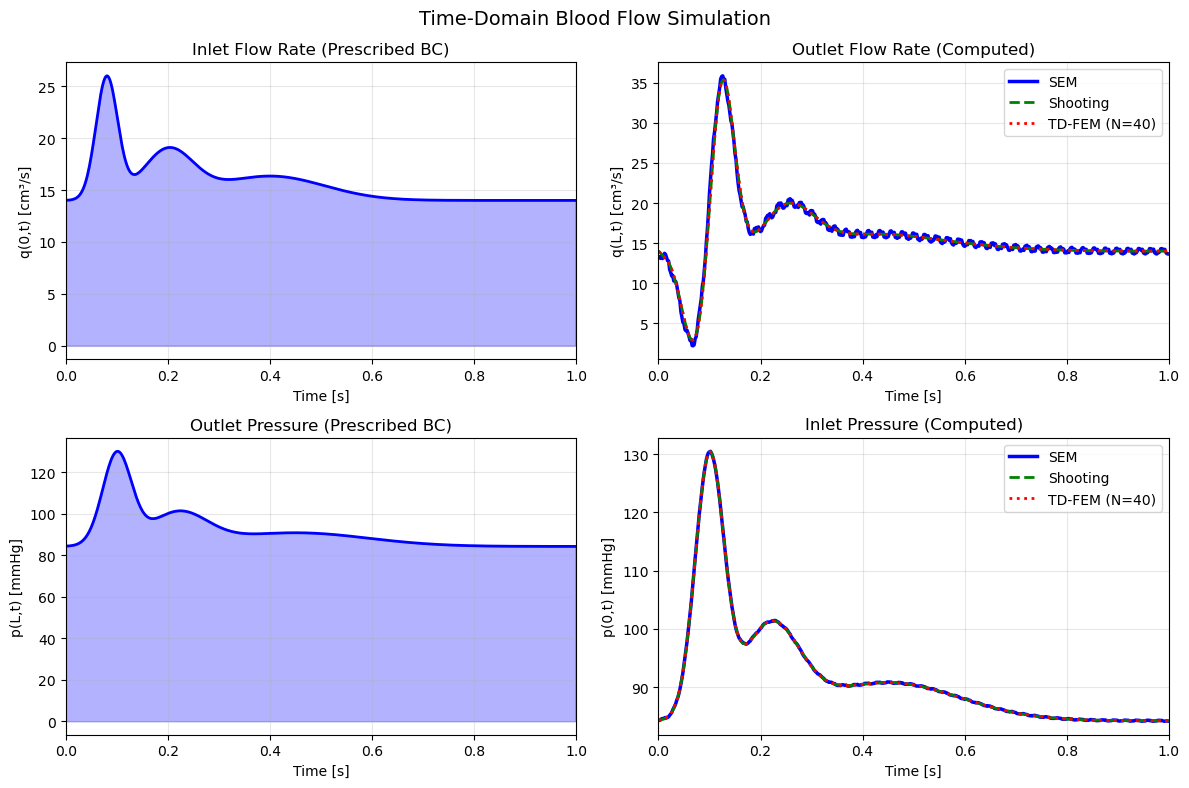


Max difference between methods:
  SEM vs TD-FEM (inlet pressure):   0.2919 mmHg
  SEM vs TD-FEM (outlet flow):      1.5965 cm³/s
  SEM vs Shooting (inlet pressure): 0.2919 mmHg
  SEM vs Shooting (outlet flow):    1.5965 cm³/s


In [24]:
N_time = 500
N_fem = 40

print("Computing SEM solution (frequency-domain)...")
start_sem = time.time()
t_sem, q_in_sem, p_in_sem, q_out_sem, p_out_sem = sem_fft_ifft(N=N_time)
end_sem = time.time()
print(f"SEM runtime: {end_sem - start_sem:.4f} seconds")


print("Computing TD-FEM solution (time-domain)...")
start_fem = time.time()
t_fem, q_in_fem, p_in_fem, p_out_fem, q_out_fem = fem_time_domain(params, N_elem=N_fem, N_time=N_time)
end_fem = time.time()
print(f"FEM runtime: {end_fem - start_fem:.4f} seconds")


print("Computing TD-Shooting solution (time-domain)...")
start_shoot = time.time()
t_shoot, _, q_in_shoot, p_in_shoot, p_out_shoot, q_out_shoot, _, _ = solve_time_domain_shooting(params, N_time=N_time)
end_shoot = time.time()
print(f"Shooting runtime: {end_shoot - start_shoot:.4f} seconds")


# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Row 1, Col 1: Inlet flow (prescribed BC)
ax = axes[0, 0]
ax.fill_between(t_sem, q_in_sem * 1e6, alpha=0.3, color='blue')
ax.plot(t_sem, q_in_sem * 1e6, 'b-', linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('q(0,t) [cm³/s]')
ax.set_title('Inlet Flow Rate (Prescribed BC)')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.3)

# Row 1, Col 2: Outlet flow (computed)
ax = axes[0, 1]
ax.plot(t_sem, q_out_sem * 1e6, 'b-', linewidth=2.5, label='SEM')
ax.plot(t_shoot, q_out_shoot * 1e6, 'g--', linewidth=2, label='Shooting')
ax.plot(t_fem, q_out_fem * 1e6, 'r:', linewidth=2, label=f'TD-FEM (N={N_fem})')
ax.set_xlabel('Time [s]')
ax.set_ylabel('q(L,t) [cm³/s]')
ax.set_title('Outlet Flow Rate (Computed)')
ax.set_xlim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)

# Row 2, Col 1: Outlet pressure (prescribed BC)
ax = axes[1, 0]
ax.fill_between(t_sem, p_out_sem / 133.322, alpha=0.3, color='blue')
ax.plot(t_sem, p_out_sem / 133.322, 'b-', linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('p(L,t) [mmHg]')
ax.set_title('Outlet Pressure (Prescribed BC)')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.3)

# Row 2, Col 2: Inlet pressure (computed)
ax = axes[1, 1]
ax.plot(t_sem, p_in_sem / 133.322, 'b-', linewidth=2.5, label='SEM')
ax.plot(t_shoot, p_in_shoot / 133.322, 'g--', linewidth=2, label='Shooting')
ax.plot(t_fem, p_in_fem / 133.322, 'r:', linewidth=2, label=f'TD-FEM (N={N_fem})')
ax.set_xlabel('Time [s]')
ax.set_ylabel('p(0,t) [mmHg]')
ax.set_title('Inlet Pressure (Computed)')
ax.set_xlim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Time-Domain Blood Flow Simulation', fontsize=14)
plt.tight_layout()
plt.savefig('plot3_time_domain_simulation.png', dpi=150, bbox_inches='tight')
plt.show()

# Print comparison
print(f"\nMax difference between methods:")
print(f"  SEM vs TD-FEM (inlet pressure):   {numpy.max(numpy.abs(p_in_sem - p_in_fem))/133.322:.4f} mmHg")
print(f"  SEM vs TD-FEM (outlet flow):      {numpy.max(numpy.abs(q_out_sem - q_out_fem))*1e6:.4f} cm³/s")
print(f"  SEM vs Shooting (inlet pressure): {numpy.max(numpy.abs(p_in_sem - p_in_shoot))/133.322:.4f} mmHg")
print(f"  SEM vs Shooting (outlet flow):    {numpy.max(numpy.abs(q_out_sem - q_out_shoot))*1e6:.4f} cm³/s")

## Discussion [15 pts]

Evaluate the results of your project including 
* Why should I believe that your numerical results are correct (convergence, test cases etc)?
* Did the project work (in your opinion)?
* If yes:  what would be the next steps to try
* If no:  Explain why your approach did not work and what you might do to fix it.


We verified the linear and nonlinear SEM solvers with two simple test cases. The first test case assumes that the stiffness matrix $\mathbf{S}$ is the identity matrix, in which case we know that inlet pressure should equal inlet flow rate and outlet pressure should equal negative outlet flow rate:
$$p_{in} = q_{out} \quad p_{out} = -q_{out}$$

We found that errors were around machine epsilon. As a result, we concluded that our SEM solver pipeline (apply boundary conditions in the time-domain, FFT to the frequency-domain, solve for unknown inlet pressure and outlet flow rate in the frequency-domain, IFFT back to the time-domain) is sound. 

The second test case involved passing a simple sinusoidal waveform into the solver (as boundary conditions). We observed that the solver produced solutions which were also sinusoidal waveforms. The solutions were smooth and bounded, matching the inputs. We concluded that the FFT/IFFT transformations were implemented correctly, that the frequency-domain solutions were numerically stable, and that the matrix inversions were well-conditioned.

For the FEM and shooting method solvers, we demonstrated three validation cases, with the last drawing a comparison between the SEM, FEM, and shooting method solvers. In the first validation case, we extracted the spatial solution at a single moment in time. The FEM converged to the same solution as the shooting method at increasingly fine meshes, which was as expected.

The second validation case considered the convergence rate of the FEM solution. We compared the FEM error against a reference solution as the number of elements increase against the theoretical convergence rate. One thing we noted was that the shooting method (reference solution) degraded as the mesh became too fine, indicating that at a very fine mesh, FEM error can be due to reference solution uncertainty rather than discretization error. 

The third validation case compared computed inlet pressure and outlet flow rate across the three methods. The three sets of solutions may be observed to overlap each other considerably, allowing us to conclude that we successfully implemented the SEM, FEM, and shooting method solvers (particularly since we dealt with two forms of the governing equations - in the time-domain and in the frequency-domain).

Moving forward, we might return to the formulation stage and do away with some simplifying assumptions we made to the governing equations and physical parameters. In particular, we might work with the strong form of the governing equations rather than the linearized form. We can change parameters we previously set to zero (such as $\theta, \psi, \tau_{\epsilon}, \tau_{\sigma}$) to more physically plausible values - e.g. we might consider the viscoelastic vessel wall, in which case $\tau_{\epsilon}, \tau_{\sigma}$ would not be zero. Additionally, we might consider a different formulation of the FEM, such as the Newton-Raphson method used in Wan et al. (2002).